# Table of Contents

The following cell generates a table of contents for ease of navigating the notebook.

In [1]:
%%javascript
Jupyter.notebook.execute_cells([0]);

<IPython.core.display.Javascript object>

# Introduction

This notebook contains a product synthesized from multiple notebooks over the course of this text analytics project. This analysis came about in partnership with the Fire Center at the University of Montana, and explores reports that combine Organizational Assesments with Relative Risk Decisions. The primary goal of the analysis was to find the text features that drive risk, but as is apparent from the vast amount of explorations contained, many smaller questions arose along the way. The data used is largely unexplored with text analytics and contains both features, categorical features, and a wealth of other variables about each fire report. 
   
The code contained in this notebook takes the data from its raw form and cleans it, tokenizes text with custom code, utilizes TFIDF vectorization to perform analysis, explores numerous approaches to statistical analysis, and concludes what, if any, valuable insights can be gained from the text.

# Imports

In the below cell I import a variety of python libraries and modules, preparing my notebook for text analysis, natural language processing, machine learning, and more.

In [1]:
# Import standard libraries.
import csv
import math
import os
import random
import re
import warnings
from collections import (Counter, 
                         defaultdict)
from datetime import timedelta
from pprint import pprint
from random import randint
from string import punctuation

# Third-party library imports
import eli5
import importlib
import ipywidgets as widgets
import janitor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import scipy.stats as stats
import seaborn as sns
import spacy
import sqlite3
import xgboost as xgb
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from IPython.display import (display,
                             clear_output)
from nltk.corpus import (stopwords,
                         words)
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from scipy.sparse import hstack
from scipy.stats import (kruskal,
                         pearsonr)
from sklearn.decomposition import PCA
from sklearn.ensemble import (BaggingClassifier,
                              RandomForestClassifier,
                              StackingClassifier)
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             precision_recall_fscore_support,
                             precision_score,
                             recall_score)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV, 
                                     train_test_split)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (LabelEncoder,
                                   StandardScaler)
from sklearn.svm import SVC
from spellchecker import SpellChecker
from textblob import TextBlob
from wordcloud import WordCloud

# Import local application/library specific imports.
from agency_involvement_functions import (adress_agency_imbalance,
                                          analyze_agency_involvement,
                                          get_agency_stats,
                                          get_most_common_words,
                                          pretty_print_results,
                                          update_agency_stats_and_features)
from oarr_cleaning import cl_names, oarr_clean_and_check
from subject_object_extraction import findSVOs
from text_analysis_functions_wagers import (analyze_sentiment,
                                            average_tfidf_vectors,
                                            basic_text,
                                            button_click_handler,
                                            completion_percentage,
                                            contains_target_word,
                                            count_ngrams,
                                            extract_context,
                                            extract_ordered_ngrams,
                                            percentage_by_risk,
                                            percentage_with_target_words,
                                            plot_function,
                                            vectorize_text_with_ngrams)
from text_classification_functions import (best_random_forest,
                                           neighbor_number_search,
                                           predict_fire_size_and_find_terms,
                                           risk_other_machine,
                                           store_coefficients,
                                           store_predict_fire_size_and_find_terms,
                                           train_knn_classifier,
                                           train_logistic_reg,
                                           train_logistic_reg_for_one_risk,
                                           train_nb_classifier,
                                           train_random_forest,
                                           try_variety_of_models)
from text_functions import (categorize_columns,
                            firestops,
                            get_last_value,
                            process_text_column,
                            set_columns_to_string)

# Load NLTK resources.
nltk.download('punkt')
nltk.download('words')
# Download the English model from Spacy.
spacy.cli.download("en_core_web_sm")
parser = spacy.load('en_core_web_sm')
# Assign stopwords variable.
sw = stopwords.words('english')

C:\Users\aidan\anaconda3\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aidan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Here I read in my raw data. The data was given to me by project managers in a csv format. All function files used for cleaning are available in the github repo.

In [2]:
# Read in the data from a csv.
OARR = pd.read_csv("OA_RRA_l2.csv", encoding='latin-1')

# Basic Cleaning and Prep

In the below cells, I first utilize pyjanitor to clean the column names in the df. I then utilize a custom function that I created to perform the following tasks on the data:

- Fix an erroneous entry in the geo_area_name column
- Check the geo_area_name column for proper completion
- Ensure that each entry has a unique identifier
- Check the fire_name column and print any nan values
- Other column quality checks (see function file for a full breakdown)

In [3]:
# Use a function to clean column names.
OARR = cl_names(OARR)

# Multi-step cleaning function for the data.
oarr_clean_and_check(OARR)

The row(s) at index Index([3890, 4050, 8616, 16751, 16752, 16753, 16754, 16755, 16756, 16757], dtype='int64') have 'nan' string values in 'fire_name'.


# Process Text

In this section of the notebook I use functions I have built to process the text data in the fire reports.

###### Identifier Creation

Below I make a unique identifier for fire-risk combinations by combining fire id and fire relative risk decision. I chose to do this to more accurately distribute text across entries for analysis. Grouping all text into each id is great in theory, but not as much in practice as many fires change risk rating. Additionally, using individual reports falls apart as well with the amount of copy-pasting that goes on from one report to another. I also set the column order and ensure that any accidental index column crossover is dealt with. 

In [4]:
# Create identifier based on risk-id combination.
OARR = OARR.assign(wfdss_risk=(OARR['wfdss_id'].astype(str) \
                               + " - " + OARR['rrf_rr_desc']))

# Re-order columns to put new identifier first.
column_order = ['wfdss_risk'] \
+ [col for col in OARR.columns if col != 'wfdss_risk']

OARR = OARR[column_order]

# Drop accidentally created column if it pops up.
if 'unnamed_0' in OARR.columns:
    OARR = OARR.drop('unnamed_0', axis=1)

###### Create Useful Lists for Later

In the below cell, I make a list containing all note columns, risk decision columns, and fire identification columns. These will be useful later in the code.

In [5]:
# Establish a list of all text fields.
notes = []
for column in OARR.columns:
    if 'notes' in column:
        notes.append(column) 

# Establish a list of all risk and sub-risk decisions.
descs = []
for column in OARR.columns:
    if 'desc' in column:
        descs.append(column)
# Create list for all identifiers       
ids =[]
for column in OARR.columns:
    if '_id' in column:
        ids.append(column)

# Create a df of only text, risk decisions, and ids.
ctk = ids + notes + descs
x_notes = notes + ['combined_text']
text_risk_id = OARR[ctk]

###### Clean & Tokenize Text

Below I clean and tokenize the raw text and store it in a dataframe.

In [6]:
# Intialization of empty list to store unique tokens.
combined_text = []

# Create a dictionary where the keys are columns 
# in the previously created notes list.
unique_sentence_dict = {col: {} for col in notes}

# Group the data by the identifier I created previously.
grouped_df = OARR.groupby('wfdss_risk')

for fire_id, group_df in grouped_df:
    for column_name in notes:
        # Call my function I imported above to process each text column.
        tokens = process_text_column(group_df, column_name)
        
        # Store the unique tokens for each column in a sub-dictionary.
        unique_sentence_dict[column_name][fire_id] = tokens
        
        for token in tokens:
            if token not in combined_text:
                combined_text.append(token)

# Create a DataFrame to store text.
temp = pd.DataFrame(unique_sentence_dict)
temp.reset_index(inplace=True)
temp.rename(columns={'index': 'wfdss_risk'}, inplace=True)

# Put the tokenized text into the DataFrame.
for col in notes:
    temp[col] = temp[col].apply(lambda x: ' '.join(x)\
                                if isinstance(x, list) else x)

# Replace blank values with nan.
temp.replace("", np.nan, inplace=True)

for col in notes:
    temp[col] = temp[col].fillna("")  
    temp[col] = temp[col].apply(lambda raw: " ".join(raw.split()) \
                                if isinstance(raw, str) else raw)
    temp[col] = temp[col].apply(lambda raw: " ".join\
                                ([t.lower() for t in raw.split() if t.lower().isalpha()\
                                  and t.lower() not in sw and t.lower() not in firestops])\
                                if isinstance(raw, str) else "")

Now I utilize the data created above to finalize a DataFrame for analysis, simply called data.

In [7]:
# Create another grouped df.
grouped_df2 = OARR.groupby('wfdss_risk')

# Utilize the get_last_value function to fill out the df.
result_df = grouped_df2.apply(lambda group: group.apply(get_last_value))

#Reset index.
result_df.reset_index(drop=True, inplace=True)

# Replace text columns to keep attribute columns.
for column in notes:
    result_df[column] = temp[column]
    
# Create a df called 'data' for simple naming.
data = result_df

# Iterate over each fire-risk to keep only non-redundant text.
for id_ in data['wfdss_risk'].unique():
    mask = data['wfdss_risk'] == id_

    for col in notes:
        for i, row in data[mask].iterrows():
            if i > 0 and not pd.isnull(row[col]) and not pd.isnull(data.loc[i - 1, col]):
                previous_text = data.loc[i - 1, col]
                current_text = row[col]
                new_text = current_text.replace(previous_text, '').strip()
                data.at[i, col] = new_text

# Create a new column containing all text for each fire-risk.
data['combined_text'] = data[notes].apply(lambda row: ' '.join(row), axis=1)

# Data Overview 

## The Reports

Here I provide a simple overview of when the data is from, and how many unique fire-risk combinations exist within it.

In [9]:
# Change start_date_time to datetime.
data['start_date_time'] = pd.to_datetime(data['start_date_time'])

# Date and fire summary statistics.
earliest_date_time = data['start_date_time'].min()
newest_date_time = data['start_date_time'].max()
date_diff = newest_date_time - earliest_date_time
total_rows = len(data)
total_fires = len(data['wfdss_id'].unique())

# Print results to screen.
print("The earliest fire report in the data is:", earliest_date_time)
print("The most recent fire report in the data is:", newest_date_time)
print(
    f"In total, the data is comprised of {total_rows} entries over about "
    f"{date_diff.days} days and {total_fires} unique fire-risk combinations. "
)

The earliest fire report in the data is: 2011-04-28 17:10:00
The most recent fire report in the data is: 2022-11-23 13:27:00
In total, the data is comprised of 7665 entries over about 4226 days and 6195 unique fire-risk combinations. 


Below I plot the distributions of amounts of reports for a given fire.

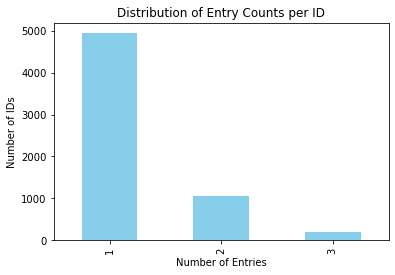

In [10]:
# Count occurences of each ID in the data.
entry_counts = data['wfdss_id'].value_counts()

# Plot the distribution of entry counts.
entry_counts.value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Entry Counts per ID')
plt.xlabel('Number of Entries')
plt.ylabel('Number of IDs')
plt.show()

# Text Overview

In this section of the notebook I provide a broad look at the text in the data, utilizing the ntotes fields for each report. This includes common tokens and n-grams, as well as basic completion statistics. More importantly, I delve into the differences in text across risks and regions, as well as provide the opportunity for exploration by tokens of an individuals choosing.

### Common Tokens

Below  is a simple wordcloud visualization of the common features in the text. This is not intended to be any form of hard-hitting analysis, but rather a visual introduction to the text.

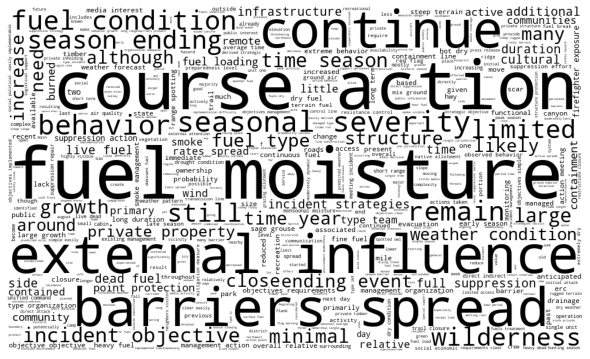

In [11]:
# Merge all text into one big list.
all_text = "".join(data['combined_text'])
text = all_text

# Set color to black.
colors = ["#000000"]

# Generate wordcloud from the list of all text.
wordcloud = WordCloud(background_color="white", max_words=500,
                      width=1000, height=600,
                      color_func=lambda *args, **kwargs: colors[0])
wordcloud.generate(all_text)

# Display the word cloud.
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Common N-grams

Now I find the most common bigrams in the text. If you wish to find a different number of n-grams, simply modify the function arguments. These bigrams give an indication of what is frequently discussed in the text. In my opinion, they are all fairly expected.

In [12]:
# Call my count_ngrams function to find
# most common n-grams in text.
result = count_ngrams(text, 2)
count = 0

# Print results.
for n_gram, frequency in result.items():
    if count < 15:
        print(f"{n_gram}: {frequency} times")
        count += 1
    else:
        break

('course', 'action'): 2360 times
('barriers', 'spread'): 2348 times
('external', 'influences'): 2233 times
('seasonal', 'severity'): 1994 times
('fuel', 'moistures'): 1636 times
('season', 'ending'): 1581 times
('incident', 'objectives'): 1391 times
('fuel', 'conditions'): 1355 times
('time', 'season'): 1350 times
('time', 'year'): 1149 times
('weather', 'conditions'): 1079 times
('private', 'property'): 1077 times
('incident', 'strategies'): 1070 times
('ending', 'event'): 1038 times
('fuel', 'moisture'): 1024 times


## Broad Data Information

Below, I calculate some descriptive statistics about the text data. I utilize functions I built for this project.

### Completion of  Notes Fields

As visible below, the majority of fields have a high completion rate. It is definitely worth noting that some fields are left blank over 10% of the time, even when multiple reports are brought into a fire-risk combination. 

In [13]:
# Call a function I made to find the percentage 
# of note field completion by fire managers.
completion_percentage(data,notes)

Below is the percantage of entires with at least some unique text for a fire-risk grouping:


{'hazf_notes': 91.29810828440965,
 'probf_notes': 88.81930854533594,
 'valf_notes': 91.1545988258317,
 'rrf_notes': 86.43183300717547,
 'spf_notes': 85.58382257012394,
 'impdif_f_notes': 87.71037181996087,
 'orgf_notes': 72.56360078277886}

### Summary Statistics of Notes Fields

In [14]:
# Call one of my functions to get summary text statistics for each text field.
results_df = basic_text(data,notes)

# Print results in a semi-legible fashion.
results_df = results_df.transpose()
results_df

,total_tokens,unique_tokens,average_tokens,avg_token_length,lexical_diversity,top_10
hazf_notes,193483,6148,25.242401,6.543438,0.031775,"[(fuel, 6516), (behavior, 5146), (fuels, 5086)..."
probf_notes,158328,6007,20.655969,6.502558,0.03794,"[(barriers, 5283), (season, 4599), (spread, 34..."
valf_notes,190057,9795,24.795434,6.934435,0.051537,"[(private, 3395), (cultural, 2331), (infrastru..."
rrf_notes,146982,6998,19.175734,6.868399,0.047611,"[(relative, 2340), (fuel, 1637), (fuels, 1632)..."
spf_notes,139675,6767,18.22244,7.315132,0.048448,"[(objectives, 3843), (private, 2847), (externa..."
impdif_f_notes,161584,6032,21.080757,7.199958,0.03733,"[(incident, 2533), (functional, 2336), (limite..."
orgf_notes,139169,6942,18.156425,7.213237,0.049882,"[(type, 2667), (objectives, 2375), (incident, ..."


In [15]:
# Perform the same process as above but for all text.
at_results = basic_text(data,['combined_text'])
at_results =at_results.transpose()

# Print results.
at_results

,average_tokens,avg_token_length,lexical_diversity,top_10,total_tokens,unique_tokens
combined_text,147.329159,6.917737,0.015104,"[(fuel, 12415), (fuels, 10156), (private, 9326...",1129278,17057


###### Export for Use in Power BI

In [16]:
# Combine the two DFs created above.
at_results2 = at_results[results_df.columns]
temp_combined_df = pd.concat([results_df, at_results2], ignore_index=False)

# Export to .csv for Power BI.
temp_combined_df.to_csv("summarytext.csv")

## Differences By Risk - What Drives Risk?

Here I explore what drives each individual risk rating decision within the data. This will be explored much more in depth later in the analysis, but for understanding factors behind each risk this is a great reference.

In [17]:
# Establish my vectorizer.
vectorizer =TfidfVectorizer()

### High

In [18]:
# Use a function imported above to create binary risk data for each risk.
high_other_comb_texts, high_other_labels = risk_other_machine(data, 'high')
mod_other_comb_texts, mod_other_labels = risk_other_machine(data, 'mod')
low_other_comb_texts, low_other_labels = risk_other_machine(data,'low')

In [19]:
# Store results from my train_logistic_reg_for_one_risk 
# function for high-risk fires.
ho_model_high_risk, ho_lrx_train_high_risk, ho_lrx_test_high_risk, \
ho_lry_train_high_risk, ho_lry_test_high_risk \
= train_logistic_reg_for_one_risk(high_other_comb_texts,
                                  high_other_labels,
                                  'high',
                                  'l2',
                                  1,
                                  1000)

# Test model accuracy.
ho_lry_pred_high_risk = ho_model_high_risk.predict(ho_lrx_test_high_risk)
ho_score_high_risk = accuracy_score(ho_lry_test_high_risk,
                                    ho_lry_pred_high_risk)

#Print results.
print(f"The model accuracy is {ho_score_high_risk}")
print("\nClassification Report:")
print(classification_report(ho_lry_test_high_risk, ho_lry_pred_high_risk))

The model accuracy is 0.7964774951076321

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       981
           1       0.77      0.62      0.69       552

    accuracy                           0.80      1533
   macro avg       0.79      0.76      0.77      1533
weighted avg       0.79      0.80      0.79      1533



###### Export for Power BI

In [20]:
# Store classification report in a dictionary.
report_dict = classification_report(ho_lry_test_high_risk,
                                    ho_lry_pred_high_risk,
                                    output_dict=True)

# Convert the classification report dictionary into a DataFrame.
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to metrics.
report_df.rename(columns={'index': 'metrics'}, inplace=True)

# Add a new row for the model accuracy at the end of the DataFrame.
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame.
final_report_df = pd.concat([report_df, accuracy_row])

# Make a risk column filled with the proper risk value.
val = 'high'
final_report_df['risk'] = val

# Print the DataFrame to ensure it looks correct.
print(final_report_df)

               metrics  precision    recall  f1-score      support  risk
0                    0   0.806599  0.897044  0.849421   981.000000  high
1                    1   0.771493  0.617754  0.686117   552.000000  high
2             accuracy   0.796477  0.796477  0.796477     0.796477  high
3            macro avg   0.789046  0.757399  0.767769  1533.000000  high
4         weighted avg   0.793958  0.796477  0.790619  1533.000000  high
accuracy           NaN        NaN       NaN  0.796477          NaN  high


In [21]:
# Export to .csv.
final_report_df.to_csv("HighClassifReport.csv")

#### Insights

The penalized logistic regression model trained above predicts fire risk at a roughly 80% accuracy rate, which is significantly better than random guessing. Overall, I am satisfied with model performance. It is important to consider that the model is not perfect, and domain expertise may outweigh the models coefficient assignments.

The below features are the 20 that the model has identified as the strongest evidence for a given fire being classified as high risk. Tokens such as 'extreme', 'dry', and 'structures' appear as the three strongest tokens in terms of evidence for this class. These are not necessarily too interesting in my opinion, but are worth noting. 

From the tokens below it is worth noting that discussions of structures, homes, and other tokens associated with human population and infrastructure make up a good chunk of these influential tokens. This would suggest, with some assumption, that this topic is one that is heavily associated with the decision to designate a fire as high risk.

Additionally, the inclusion of 'team' and 'imt' (Incident Management Team) would suggest that the discussion of operational activities is possibly an indicator of a high relative risk designation.

In [22]:
# The texts had been vectorized inside the function that made the model
# However, I must do so again here.
txt = vectorizer.fit_transform(high_other_comb_texts)

# Pull text features and coefficients from the model.
feature_names = vectorizer.get_feature_names_out()
coefficients = ho_model_high_risk.coef_[0]

# Zip feature coefficient pairs and sort by highest coefficient.
feature_coefficients = dict(zip(feature_names, coefficients))
sorted_features = sorted(feature_coefficients.items(),
                         key=lambda x: x[1],
                         reverse=True)

# Print the top coefficients.
top_features = sorted_features[:20] 
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: extreme, Coefficient: 4.967278913815581
Feature: dry, Coefficient: 3.080155686925375
Feature: structures, Coefficient: 3.0428456532716357
Feature: large, Coefficient: 2.495758377662233
Feature: difficult, Coefficient: 2.472532110309322
Feature: team, Coefficient: 2.447416885834606
Feature: state, Coefficient: 2.3840279694045963
Feature: homes, Coefficient: 2.2353642013571284
Feature: continuous, Coefficient: 2.2214947352848764
Feature: record, Coefficient: 2.1821903050749074
Feature: imt, Coefficient: 2.0479331385162336
Feature: evacuations, Coefficient: 2.005251263710495
Feature: communities, Coefficient: 2.0021197332431218
Feature: throughout, Coefficient: 1.9792924761846107
Feature: long, Coefficient: 1.9647846303098824
Feature: crown, Coefficient: 1.9469276657341863
Feature: availability, Coefficient: 1.9451836488006538
Feature: community, Coefficient: 1.9125717677077896
Feature: spotting, Coefficient: 1.9051218781987753
Feature: private, Coefficient: 1.8914392084734881


###### Export for Power BI

In [23]:
# Put the feature-coefficient pairs in a DF and label with the proper risk.
feature_coefficients_df = pd.DataFrame(top_features, columns=['Feature',
                                                              'Coefficient'])
feature_coefficients_df['risk'] = 'high'

### Moderate

In [24]:
# Repeat the model training process for moderate-risk fires.
mod_logreg_model, modx_train, modx_test, mody_train, mody_test \
=train_logistic_reg_for_one_risk(mod_other_comb_texts,
                                 mod_other_labels,
                                 'mod',
                                 'l2',
                                 1,
                                 1000)

# Predict on testing data and evaluate model.
mody_pred = mod_logreg_model.predict(modx_test)
mod_logreg_acc = accuracy_score(mody_test, mody_pred)

# Print classification report to screen.
print(f"The model accuracy is {mod_logreg_acc}")
print("\nClassification Report:")
print(classification_report(mody_test, mody_pred))

The model accuracy is 0.6151337247227658

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       952
           1       0.48      0.20      0.28       581

    accuracy                           0.62      1533
   macro avg       0.56      0.53      0.51      1533
weighted avg       0.58      0.62      0.56      1533



In [25]:
# Store classification results in a DataFrame.
report_dict = classification_report(mody_test,
                                    mody_pred,
                                    output_dict=True)

# Convert the classification report dictionary into a DataFrame.
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to metrics.
report_df.rename(columns={'index': 'metrics'}, inplace=True)
# Add a new row for the model accuracy at the end of the DataFrame.
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame.
final_report_df2 = pd.concat([report_df, accuracy_row])

# Indicate moderate risk in the DF.
val = 'mod'
final_report_df2['risk'] = val

# Print the DataFrame to ensure it looks correct.
print(final_report_df2)

               metrics  precision    recall  f1-score      support risk
0                    0   0.639660  0.870798  0.737544   952.000000  mod
1                    1   0.481013  0.196213  0.278729   581.000000  mod
2             accuracy   0.615134  0.615134  0.615134     0.615134  mod
3            macro avg   0.560337  0.533506  0.508137  1533.000000  mod
4         weighted avg   0.579534  0.615134  0.563655  1533.000000  mod
accuracy           NaN        NaN       NaN  0.796477          NaN  mod


#### Insights

A penalized logistic regression does not perform as well predicting moderate risk fires as it does the other risks. In fact, it predicts nearly 20% less accurately! At only about 62%, this result is not too impressive. In this case, be sure to consider the models accuracy when assessing the features that drive model decisions.

These top features are much less informative or immediately intuitive than those for high and low risk fires, but are still worth looking at. The presence of 'average', for example, does seem rather intuitive. Interestingly, the token 'hunting' appears in the top 20 tokens that present the strongest evidence. It may be worth exploring a connection between leisure activities and risk designation.

The tokens here seem more descriptive of fire control efforts than those for high risk, which were the actual units. Tokens like 'solely', 'mitigated', 'efforts', 'sufficient', 'adequate' and 'containment' could possibly support this statement.

In [26]:
# Again, vectorize text. See high risk for explanation.
txt = vectorizer.fit_transform(mod_other_comb_texts)

# Pull features and coefficients from model.
feature_names = vectorizer.get_feature_names_out()
coefficients = mod_logreg_model.coef_[0]

# Zip feature coefficient pairs.
feature_coefficients = dict(zip(feature_names, coefficients))
sorted_features = sorted(feature_coefficients.items(),
                         key=lambda x: x[1],
                         reverse=True)

# Sort and print top coefficients for moderate risk fires.
top_features = sorted_features[:20] 
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: still, Coefficient: 2.0477254451736275
Feature: average, Coefficient: 1.6434273518630784
Feature: scars, Coefficient: 1.6221020963720856
Feature: consists, Coefficient: 1.5329817089138131
Feature: away, Coefficient: 1.4572253486806332
Feature: mitigated, Coefficient: 1.4318488237626685
Feature: solely, Coefficient: 1.373769420301688
Feature: efforts, Coefficient: 1.3430590790599508
Feature: vegetation, Coefficient: 1.332073471364472
Feature: hunting, Coefficient: 1.2954144467171547
Feature: slightly, Coefficient: 1.2675309330346178
Feature: sufficient, Coefficient: 1.2356228936457827
Feature: short, Coefficient: 1.2275438418215538
Feature: containment, Coefficient: 1.2083918796574313
Feature: organization, Coefficient: 1.191447300660525
Feature: term, Coefficient: 1.1267809023489432
Feature: surface, Coefficient: 1.1153390091515014
Feature: joker, Coefficient: 1.1127915679735803
Feature: although, Coefficient: 1.1069534243764918
Feature: adequate, Coefficient: 1.10022687280631

In [27]:
# Store feature coefficient pairs in a DF for later Power BI use.
feature_coefficients_df2 = pd.DataFrame(top_features, columns=['Feature',
                                                               'Coefficient'])
feature_coefficients_df2['risk'] = 'mod'

### Low

In [28]:
# Use the same function again, this time for low-risk fire.
low_logreg_model, lowx_train, lowx_test, lowy_train, lowy_test \
= train_logistic_reg_for_one_risk(low_other_comb_texts, 
                                  low_other_labels, 
                                  'low', 
                                  'l2', 
                                  1, 
                                  1000)

# Predict on testing data and caclulate metrics.
lowy_pred = low_logreg_model.predict(lowx_test)
low_logreg_acc = accuracy_score(lowy_test, lowy_pred)

# Print classification report to the screen.
print(f"The model accuracy is {low_logreg_acc}")
print("\nClassification Report:")
print(classification_report(lowy_test, lowy_pred))

The model accuracy is 0.79191128506197

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1133
           1       0.75      0.30      0.43       400

    accuracy                           0.79      1533
   macro avg       0.77      0.63      0.65      1533
weighted avg       0.78      0.79      0.76      1533



In [29]:
# Store results in DF for Power BI use.
report_dict = classification_report(lowy_test,
                                    lowy_pred,
                                    output_dict=True)

# Convert the classification report dictionary into a DataFrame.
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to 'metrics'.
report_df.rename(columns={'index': 'metrics'}, inplace=True)

# Add a new row for the model accuracy at the end of the DataFrame.
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame.
final_report_df3 = pd.concat([report_df, accuracy_row])

# Assign proper risk value.
val = 'low'
final_report_df3['risk'] = val


# Print the DataFrame to ensure it looks correct.
print(final_report_df3)

               metrics  precision    recall  f1-score      support risk
0                    0   0.797080  0.963813  0.872553  1133.000000  low
1                    1   0.748466  0.305000  0.433393   400.000000  low
2             accuracy   0.791911  0.791911  0.791911     0.791911  low
3            macro avg   0.772773  0.634406  0.652973  1533.000000  low
4         weighted avg   0.784396  0.791911  0.757964  1533.000000  low
accuracy           NaN        NaN       NaN  0.796477          NaN  low


#### Insights

Low risk fires are classified at nearly the same exact accuracy as high risk fires. A penalized logistic regression model classifies text to low risk fires at nearly 80% accuracy. This is definitely a satisfactory perofrmance, given the text being worked with.

The model's delineation of features for low-risk fires reveals a starkly different landscape from those associated with moderate or high-risk classifications. Many of the tokens indicative of a low risk fire are intuitive, or may feel obvious, but there are interesting themes that can be observed.

Meteorological conditions, indicated by 'precipitation', 'rain', 'monsoonal', 'snow', and 'moisture', emerge as significant factors in reducing fire risk. These terms collectively point to the critical role of precipitation patterns in mitigating fire potential, with moisture acting as a natural suppressant that diminishes the likelihood and severity of fires.

The use of tokens like 'minimal' (the strongest evidence for a low risk fire), 'little', and easily, suggest that words that could come off as downplaying a situation are seemingly almost always used when the situation is under control. The tokens 'sparse' and 'little' indicate that discussion of scarcity could also be predictive of a low risk fire.



In [30]:
# Vectorize text.
txt = vectorizer.fit_transform(low_other_comb_texts)

# Pull features and coeficients for low-risk model.
feature_names = vectorizer.get_feature_names_out()
coefficients = low_logreg_model.coef_[0]

# Zip feature coefficient pairs.
feature_coefficients = dict(zip(feature_names, coefficients))
sorted_features = sorted(feature_coefficients.items(),
                         key=lambda x: x[1],
                         reverse=True)

# Present top features for this model by coefficient score.
top_features = sorted_features[:20] 
for feature, coefficient in top_features:
    print(f"Feature: {feature}, Coefficient: {coefficient}")

Feature: minimal, Coefficient: 3.751127560896262
Feature: monitor, Coefficient: 2.78498244251598
Feature: precipitation, Coefficient: 2.6850898151898215
Feature: sparse, Coefficient: 2.390884138982884
Feature: little, Coefficient: 2.3076974354828557
Feature: surrounded, Coefficient: 2.2915912629886646
Feature: monitoring, Coefficient: 2.1893136293717492
Feature: late, Coefficient: 2.1422054382101163
Feature: fall, Coefficient: 2.0684302820456004
Feature: rain, Coefficient: 2.04527895417375
Feature: received, Coefficient: 2.0352428790090915
Feature: repair, Coefficient: 2.0179913706566173
Feature: contained, Coefficient: 1.9896983461735585
Feature: smoldering, Coefficient: 1.970676454890964
Feature: monsoonal, Coefficient: 1.9555764410773793
Feature: monitored, Coefficient: 1.9312947793688513
Feature: snow, Coefficient: 1.9111606152150724
Feature: elevation, Coefficient: 1.8597346359542761
Feature: moisture, Coefficient: 1.8501849811824986
Feature: easily, Coefficient: 1.727304269117709

###### Power BI Export - Coefficients

In [31]:
# Store top coefficient feature pairs in a DataFrame.
feature_coefficients_df3 = pd.DataFrame(top_features, columns=['Feature',
                                                               'Coefficient'])
feature_coefficients_df3['risk'] = 'low'

In [32]:
# Combine all DFs and export to .csv for use in Power BI.
feature_coefficients_df_final = pd.concat([feature_coefficients_df,
                                           feature_coefficients_df2,
                                           feature_coefficients_df3],
                                          ignore_index=True)

feature_coefficients_df_final.to_csv("features3risksingleclass.csv")

###### Power BI Export - Model Stats

In [33]:
# Combine and export classification report metrics.
combined_df = pd.concat([final_report_df, 
                         final_report_df2,
                         final_report_df3],
                         ignore_index=True)

combined_df.to_csv("singleriskclass.csv")

## Regional Differences

In this part of the notebook I examine differences in text by region in the data. The region column is actually named geo_area_name in the data. 

### Risk

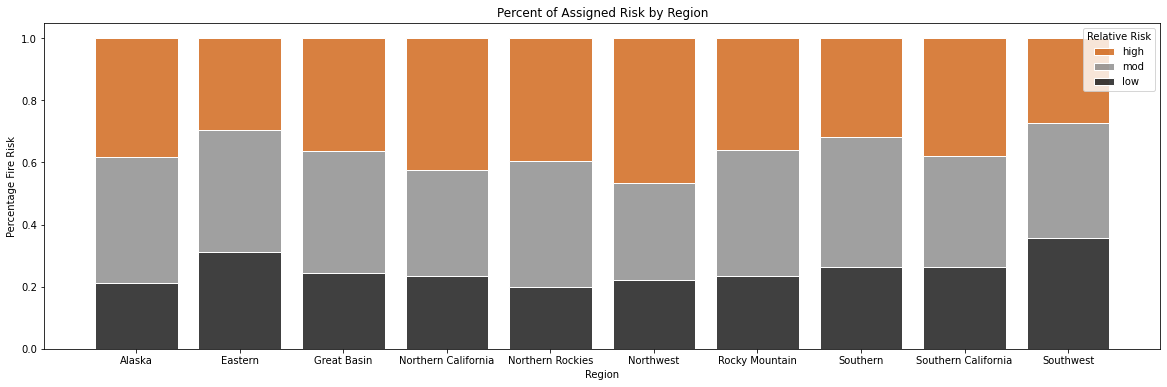

In [34]:
# Group data by region and risk and count amounts.
df_grouped = data.groupby(['geo_area_name', 
                           'rrf_rr_desc']).size().reset_index(name='count')
region_total = df_grouped.groupby('geo_area_name')['count'].sum()
df_merged = pd.merge(df_grouped, 
                     region_total, 
                     left_on='geo_area_name', 
                     right_index=True, 
                     suffixes=('', '_total'))
df_merged['percent'] = df_merged['count'] / df_merged['count_total']

df_result = df_merged[['count', 'geo_area_name', 'rrf_rr_desc', 'percent']] \
            .sort_values(['geo_area_name', 'count'], ascending=[True, False])

# Order risks logically.
custom_order = ['high', 'mod', 'low']

# Reorder the 'rrf_rr_desc' column based on the custom order.
df_result['rrf_rr_desc'] = pd.Categorical(df_result['rrf_rr_desc'], 
                                          categories=custom_order, 
                                          ordered=True)

# Plot the stacked histogram..
ax = sns.histplot(
    df_result,
    x='geo_area_name',
    weights='percent',
    hue='rrf_rr_desc',
    multiple='stack',
    palette=['#cc5500', '#808080','#000000','#000000'],
    edgecolor='white',
    shrink=0.8
)

ax.set_title('Percent of Assigned Risk by Region')
ax.set(xlabel='Region', ylabel='Percentage Fire Risk')
legend = ax.get_legend()
legend.set_title('Relative Risk')

fig = ax.get_figure()
fig.set_size_inches(20, 6)

plt.show()

In [35]:
# Here I use pearson correlation to determine if there is a statistical
# correlation between number of fires and percentage of fires designated high risk.
df_result['total_fire'] = df_result.groupby('geo_area_name')['count']\
                             .transform('sum')
df3 = df_result[df_result['rrf_rr_desc'] == ("high")]
x = df3['total_fire'].corr(df3['percent'])

print(
    f"The percentage of fires designated as high risk has a correlation "
    f"coefficient of {round(x, 6)} with the number of total fires"
)

The percentage of fires designated as high risk has a correlation coefficient of 0.290057 with the number of total fires


### Text

##### Disproportionate Tokens

In [36]:
# Make a set to hold valid words for thresholding.
valid_word_set = set(words.words())

# Get text for each region.
regions = data['geo_area_name'].unique()
region_texts = {
    region: " ".join(data[data['geo_area_name'] == region]['combined_text']) 
    for region in regions
}

# Store texts for use later.
region_token_freqs = {region: FreqDist(word_tokenize(text.lower())) for region, 
                      text in region_texts.items()}
tokens_relative_freq = {}

# Calculating relative frequencies of tokens for each region compared to other regions.
for region, freq_dist in region_token_freqs.items():
    other_regions_freq = {
        other_region: FreqDist(word_tokenize(text.lower())) 
        for other_region, text in region_texts.items() 
        if other_region != region
    }
    
    # Initializing dictionary for the current region.
    tokens_relative_freq[region] = {}
    
    for token, freq in freq_dist.items():
        # Calculate total frequency of the token in other regions.
        other_regions_total_freq = sum(
            [other_freq[token] for other_freq in other_regions_freq.values() 
                    if token in other_freq]
        )
        # Calculate relative frequency.
        relative_freq = freq / (other_regions_total_freq + freq) 
        # Store relative frequency of each token for the current region.
        tokens_relative_freq[region][token] = relative_freq

# Identifying and displaying top unique words for each region.
for region, token_freqs in tokens_relative_freq.items():
    text = region_texts[region]  
    tokens = word_tokenize(text.lower())  
    
    region_freq_dist = FreqDist(tokens) 
    
    # Sort words by relative frequency.
    top_words = [{'word': word, 'freq': freq, 'count': region_freq_dist[word]} 
             for word, freq in token_freqs.items() 
             if word.isalpha() and word.lower() in valid_word_set 
             and region_freq_dist[word] > 10 and freq < 1.0]
    top_words = sorted(top_words, key=lambda x: x['freq'], reverse=True)[:10]
    
    # Outputting the results for each region.
    print(f"Region {region}: Top Valid Words (Appearing >10 times) "
      f"with Frequencies and Counts:")
    
    for word_info in top_words:
        word = word_info['word']
        word_freq = word_info['freq']
        word_count = word_info['count']
        print(f"'{word}' (Frequency: {word_freq}, Count: {word_count})")
    print()

Region Southern: Top Valid Words (Appearing >10 times) with Frequencies and Counts:
'arson' (Frequency: 0.9047619047619048, Count: 19)
'stumpy' (Frequency: 0.9, Count: 18)
'canal' (Frequency: 0.875, Count: 14)
'parkway' (Frequency: 0.8666666666666667, Count: 13)
'swamp' (Frequency: 0.8305084745762712, Count: 49)
'cypress' (Frequency: 0.8301886792452831, Count: 44)
'irene' (Frequency: 0.8125, Count: 13)
'clay' (Frequency: 0.7857142857142857, Count: 11)
'organic' (Frequency: 0.7065217391304348, Count: 65)
'outer' (Frequency: 0.6875, Count: 11)

Region Southwest: Top Valid Words (Appearing >10 times) with Frequencies and Counts:
'apache' (Frequency: 0.9821428571428571, Count: 110)
'fe' (Frequency: 0.9629629629629629, Count: 26)
'sunflower' (Frequency: 0.9615384615384616, Count: 25)
'outlet' (Frequency: 0.9473684210526315, Count: 18)
'cuckoo' (Frequency: 0.9333333333333333, Count: 14)
'calf' (Frequency: 0.9285714285714286, Count: 13)
'mesquite' (Frequency: 0.9285714285714286, Count: 13)
'c

###### Power BI Export

In [37]:
# Repeat the last cell but store in power BI.
# Refer to the above cells code comments with any confusion.

valid_word_set = set(words.words())

regions = data['geo_area_name'].unique()
region_texts = {region: " ".join(data[data['geo_area_name'] == region]['combined_text']) for region in regions}

region_token_freqs = {region: FreqDist(word_tokenize(text.lower())) for region, text in region_texts.items()}

tokens_relative_freq = {}

# Initialize list for DataFrame rows.
df_rows = []

for region, freq_dist in region_token_freqs.items():
    other_regions_freq = {
        other_region: FreqDist(word_tokenize(text.lower())) 
        for other_region, text in region_texts.items() 
        if other_region != region
    }
    
    tokens_relative_freq[region] = {}
    for token, freq in freq_dist.items():
        other_regions_total_freq = sum([other_freq[token] 
                                for other_freq in other_regions_freq.values() 
                                if token in other_freq])
        relative_freq = freq / (other_regions_total_freq + freq)
        
        tokens_relative_freq[region][token] = relative_freq

for region, token_freqs in tokens_relative_freq.items():
    text = region_texts[region]  
    tokens = word_tokenize(text.lower())  
    
    region_freq_dist = FreqDist(tokens) 
    
    top_words = [
        {
            'region': region, 
            'word': word, 
            'relative_freq': freq, 
            'count': region_freq_dist[word]
        } 
        for word, freq in token_freqs.items() 
        if (word.isalpha() and 
            word.lower() in valid_word_set and 
            region_freq_dist[word] > 10 and 
            freq < 1.0)
    ]
    top_words = sorted(top_words, key=lambda x: x['relative_freq'], reverse=True)[:10]
    
    # Append each word's info as a dictionary to df_rows.
    df_rows.extend(top_words)

# Create DataFrame.
df = pd.DataFrame(df_rows)

#Export the dataframe to .csv for use in Power BI.
df.to_csv("region_disproportion_words.csv")


## Tokens of Interest

In this section of the notebook I run analyses that a user can change the words targeted within.

###### Set target words below!

In [38]:
# Let user set target words.
target_words = ["suppression", 
                "containment", 
                "structure", 
                "communities", 
                "barriers", 
                "smoke"]

In [39]:
# Make a df for token of interest analysis.
toi = data[x_notes + descs]

### How often do they appear?

In [40]:
# Run function to determine what percentage of entries contain the given tokens.
percentage_with_target_words(toi,target_words)

The word 'smoke' appears in 32.41% of the combined notes fields for fires.


In [41]:
# Run another function that does the same as above, but differentiated by risk.
percentage_by_risk(toi, target_words)

Risk: Low
The word 'smoke' appears in 32.85% of the texts for this risk.



### Let's take a look at common ngrams

In [42]:
# Repeat the same process as above but with a split on risk.
# With any code questions refer to the above cell.

# Create dictionaries to hold context risks and common context words.
con_risk_dict = {}  # Updated from conDict.
context_words_dict = {}  # Updated from cwd.
context_window_size = 5

# Iterate over target words.
for word in target_words:
    con_risk_dict[word] = {}
    context_words_dict[word] = {}  # Initialize context_words_dict[word] as an empty dictionary.
    
    for index, row in toi.iterrows():
        risk_description = row['rrf_rr_desc']
        text = row['combined_text']
        
         # If the risk description doesn't exist for the current word, initialize it.
        if risk_description not in con_risk_dict[word]:
            con_risk_dict[word][risk_description] = []

        contexts = extract_context(text, word, context_window_size)
        con_risk_dict[word][risk_description].extend(contexts)
    
    # Analyze collected contexts for each risk description associated with the word.
    for risk_description, c in con_risk_dict[word].items():
        all_words = [
            w.lower() 
            for context in c 
            for w in context 
            if not w.lower() == word
        ]
        common_words = Counter(all_words).most_common(5)  # Can change 5 to the desired number of common words.
        # Store the most common words for this risk description in context_words_dict.
        context_words_dict[word][risk_description] = common_words

In [43]:
# Establish empty dictionary.
common_ordered_ngrams_by_risk = {}

# Iterate through target words.
for word in target_words:
    # Dictionary for current words context.
    common_ordered_ngrams_by_risk[word] = {}
    for risk_description, contexts in con_risk_dict[word].items(): 
        # Extract trigrams
        ordered_ngrams = extract_ordered_ngrams(contexts, 3)
        #Count occurences of n-grams.
        ordered_ngram_counts = Counter(ordered_ngrams)
        # Pull 10 most common n-grams.
        most_common_ordered_ngrams = ordered_ngram_counts.most_common(10)
        # Store most common n-grams.
        common_ordered_ngrams_by_risk[word][risk_description] \
        = most_common_ordered_ngrams

# Iterate through words and print common n-grams.
for word, risk_descriptions in common_ordered_ngrams_by_risk.items():
    print(f"Word: {word}")
    for risk_description, ngram_counts in risk_descriptions.items():
        print(f"  Risk Description: {risk_description}")
        print("    Most Common Ordered Ngrams:")
        for ngram, count in ngram_counts:
            print(f"      {ngram}: {count}")
        print()  # Add an empty line between risk descriptions.
    print()  # Add an empty line between risks.

Word: suppression
  Risk Description: mod
    Most Common Ordered Ngrams:
      full suppression strategy: 50
      suppression actions taken: 29
      conditions shortages suppression: 25
      likelihood success least: 25
      unusual conditions shortages: 24
      shortage suppression response: 23
      shortages suppression shortage: 22
      suppression shortage suppression: 22
      appropriate suppression protect: 22
      suppression protect cultural: 20

  Risk Description: high
    Most Common Ordered Ngrams:
      full suppression smallest: 143
      full suppression strategy: 128
      suppression smallest possible: 114
      objectives full suppression: 105
      full suppression objectives: 87
      conflict full suppression: 84
      suppression objectives full: 72
      involved coordinated suppression: 60
      strategies full suppression: 59
      conducive highly involved: 56

  Risk Description: low
    Most Common Ordered Ngrams:
      suppression repair work: 21


# Sentiment Analyses 

In [44]:
# Copy data to use for sentiment analysis.
sent_data = data.copy()
cols_to_analyze = notes.copy()
cols_to_analyze.append('combined_text')

In [45]:
# Determine polarity and subjectivity for entries in each text column.
for col in cols_to_analyze:
    sent_data[[f'{col}_polarity',
               f'{col}_subjectivity']] \
    = sent_data[col].apply(lambda x: pd.Series(analyze_sentiment(x)))

### Subjectivity

In [46]:
# Pull subjectivity columns.
subjectivity_cols = [
    col for col in sent_data.columns 
    if 'subjectivity' in col
]

# Take the mean for each column.
average_subjectivity = {
    col: sent_data[col].mean() 
    for col in subjectivity_cols
}


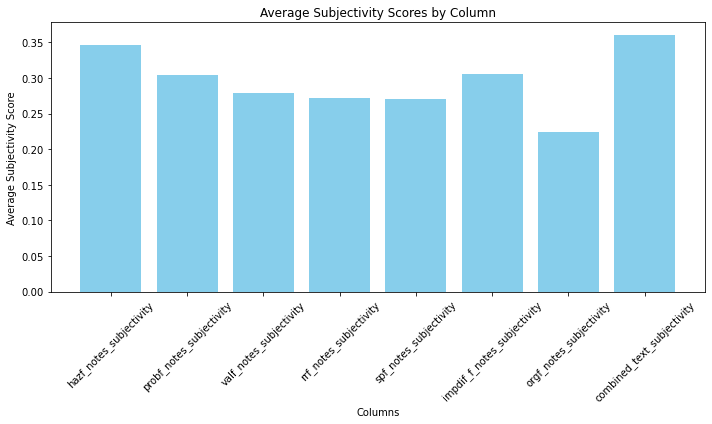

In [47]:
# Extract key value pairs from average subjectivity dictionary.
categories = average_subjectivity.keys()
scores = average_subjectivity.values()

# Creating the bar chart.
plt.figure(figsize=(10, 6))
plt.bar(categories, scores, color='skyblue')
plt.title('Average Subjectivity Scores by Column')
plt.xlabel('Columns')
plt.ylabel('Average Subjectivity Score')
plt.xticks(rotation=45)

# Show the plot below.
plt.tight_layout() 
plt.show()

In [48]:
# This cell checks for the maximum and minimum subjectivity score.

max_min_subj = {}

for col in subjectivity_cols:
    max_val = sent_data[col].max()
    min_val = sent_data[col].min()
    
    max_min_subj[col] = {'max':max_val, 'min':min_val}

# Print dataframe to screen.
max_min_subj_df = pd.DataFrame(max_min_subj).T
max_min_subj_df

,max,min
hazf_notes_subjectivity,1.0,0.0
probf_notes_subjectivity,1.0,0.0
valf_notes_subjectivity,1.0,0.0
rrf_notes_subjectivity,1.0,0.0
spf_notes_subjectivity,1.0,0.0
impdif_f_notes_subjectivity,1.0,0.0
orgf_notes_subjectivity,1.0,0.0
combined_text_subjectivity,1.0,0.0


###### Examine 1.0 Values

In [49]:
# Read outlier values to ensure there is nothing too odd happening.
for col in subjectivity_cols:
    # Identify the original text column name by removing '_Subjectivity'.
    text_col = col.replace('_subjectivity', '')
    
    # Filter the DataFrame for rows where the subjectivity score is 1.0.
    max_subjectivity_texts = sent_data[sent_data[col] == 1.0][text_col]
    
    print(f"Texts with max subjectivity in {text_col}:")
    for text in max_subjectivity_texts.head(10):
        print(text)
    break

Texts with max subjectivity in hazf_notes:
bug kill behavior drying cold front passage size behavior drying trend could moved size
extreme behavior rates difficult control even using anticipating haines ercs
grass brush toward prefedio footprint china grass brush toward prefedio footprint china grass brush toward prefedio china precipitation received slowing forward rate precipitation occurred slowing forward rate appreciable amount precipitation occurred slowing forward rate heel flanks cold rain grass
extreme behavior rapid growth power lines
tundra fuels likely rained soon called
behavior fuel types moisture levels extreme behavior forecast indicating relief worsening
burnning since fuel moisture inhibit intense growth lack access continuity fuels
fuels extremely behavior shown rapid
become established continous fuels likely continue grow weather change
fuel loading extreme drought excessively humidities weather patterns created explosive conditions resulting rapid advance


### Polarity

In [50]:
# Pull polarity columns.
polarity_cols = [col for col in sent_data.columns if 'polarity' in col]

# Find mean of polarity for each text column.
average_polarity = {col: sent_data[col].mean() for col in polarity_cols}

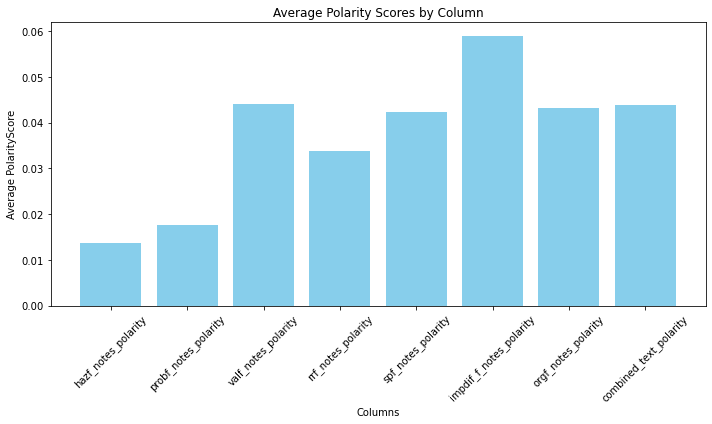

In [51]:
# Pull key value pairs from  average_polarity.
categories = average_polarity.keys()
scores = average_polarity.values()

# Creating the bar chart.
plt.figure(figsize=(10, 6))
plt.bar(categories, scores, color='skyblue')
plt.title('Average Polarity Scores by Column')
plt.xlabel('Columns')
plt.ylabel('Average PolarityScore')
plt.xticks(rotation=45)

# Display the plot on screen.
plt.tight_layout() 
plt.show()

In [52]:
# This cell examines max and min polarity values.

max_min_pola = {}

for col in polarity_cols:
    max_val = sent_data[col].max()
    min_val = sent_data[col].min()
    
    max_min_pola[col] = {'max':max_val, 'min':min_val}
    
# Print DataFrame to screen.
max_min_pola_df = pd.DataFrame(max_min_pola).T
max_min_pola_df

,max,min
hazf_notes_polarity,1.0,-0.9
probf_notes_polarity,1.0,-0.6
valf_notes_polarity,1.0,-0.8
rrf_notes_polarity,1.0,-0.8
spf_notes_polarity,1.0,-0.5
impdif_f_notes_polarity,1.0,-1.0
orgf_notes_polarity,1.0,-0.5
combined_text_polarity,1.0,-0.5


In [53]:
for col in polarity_cols:
    # Identify the original text column name by removing '_Subjectivity'.
    text_col = col.replace('_polarity', '')
    
    # Filter the DataFrame for rows where the subjectivity score is 1.0.
    max_polarity_texts = sent_data[sent_data[col] == 1.0][text_col]
    
    print(f"Texts with max polarity in {text_col}:")
    for text in max_polarity_texts.head(10):
        print(text)

Texts with max polarity in hazf_notes:
occurs murphy ridge timber spotting grass behavior best described passive crown size estimated size estimated
Texts with max polarity in probf_notes:
handcrews making excellent progress remaining probibility growth reduced probibility smokes visible
barriers greatest spread season severity season region surrounding
Texts with max polarity in valf_notes:
mount magazine state park lodge scenic viewing state hwy state park property mile wind district excellent community support wildland suppression
emigrant infrastructure wilderness greatest management
Texts with max polarity in rrf_notes:
greatest linked behavior firefighter safety mortality levels trees result mountain pine beetle mitigation hazard priority personnel involved mitigation hazard priority personnel involved incident addressed throughout incident controlled remaining associated hazard trees result mountain pine beetle poses firefighters perform remaining checks calling
risks greatest f

In [54]:
for col in polarity_cols:
    # Identify the original text column name by removing '_Subjectivity'.
    text_col = col.replace('_polarity', '')
    
    # Filter the DataFrame for rows where the subjectivity score is -1.0.
    max_polarity_texts = sent_data[sent_data[col] == -1.0][text_col]
    
    # Print -1 values, if any, for each text field.
    print(f"Texts with min polarity in {text_col}:")
    for text in max_polarity_texts.head(10):
        print(text)


Texts with min polarity in hazf_notes:
Texts with min polarity in probf_notes:
Texts with min polarity in valf_notes:
Texts with min polarity in rrf_notes:
Texts with min polarity in spf_notes:
Texts with min polarity in impdif_f_notes:
devastating history make implementing course
Texts with min polarity in orgf_notes:
Texts with min polarity in combined_text:


## Sentiment in Relationship to Risk Decision

### Subjectivity

In [55]:
# Get mean of subjectivity for each text column.
avg_subj_by_category \
= sent_data.groupby('rrf_rr_desc')[subjectivity_cols].mean().reset_index()

# Get risk labels.
categories = avg_subj_by_category['rrf_rr_desc'].unique()

# Get number of text fields.
n_text_fields = len(avg_subj_by_category.columns) - 1

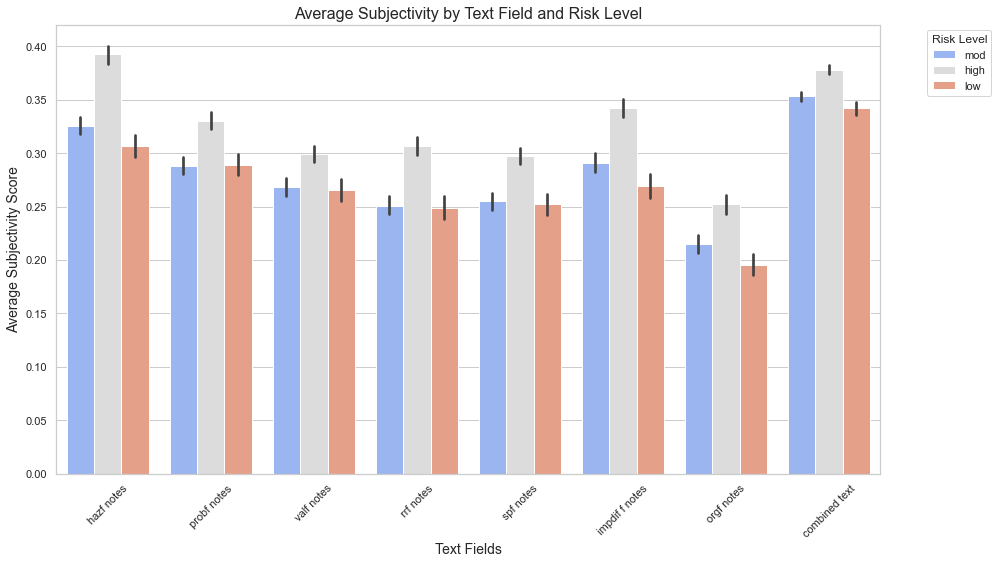

In [56]:
# Melting the DataFrame to have a long format to facilitate the use of Seaborn for clustered bar chart.
melted_data = sent_data.melt(id_vars=['rrf_rr_desc'], 
                             value_vars=subjectivity_cols, 
                             var_name='Text_Field', 
                             value_name='Average_Subjectivity')

# Remove the _subjectivity to reduce clutter.
melted_data['Text_Field'] = (
    melted_data['Text_Field']
    .str.replace('_subjectivity', '')
    .str.replace('_', ' ')
)


plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Creating the bar plot.
ax = sns.barplot(x='Text_Field', 
                 y='Average_Subjectivity', 
                 hue='rrf_rr_desc', 
                 data=melted_data, 
                 palette="coolwarm")

# Adding labels and title.
plt.xlabel('Text Fields', 
           fontsize=14)
plt.ylabel('Average Subjectivity Score', 
           fontsize=14)
plt.title('Average Subjectivity by Text Field and Risk Level', 
          fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Risk Level', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left')

plt.tight_layout()
plt.show()

### Polarity

In [57]:
# Get average polarity for each text column.
avg_pola_by_category = sent_data.groupby('rrf_rr_desc')[polarity_cols].mean().reset_index()

# Get risk labels.
categories = avg_pola_by_category['rrf_rr_desc'].unique()

# Get number of text fields.
n_text_fields = len(avg_pola_by_category.columns) - 1

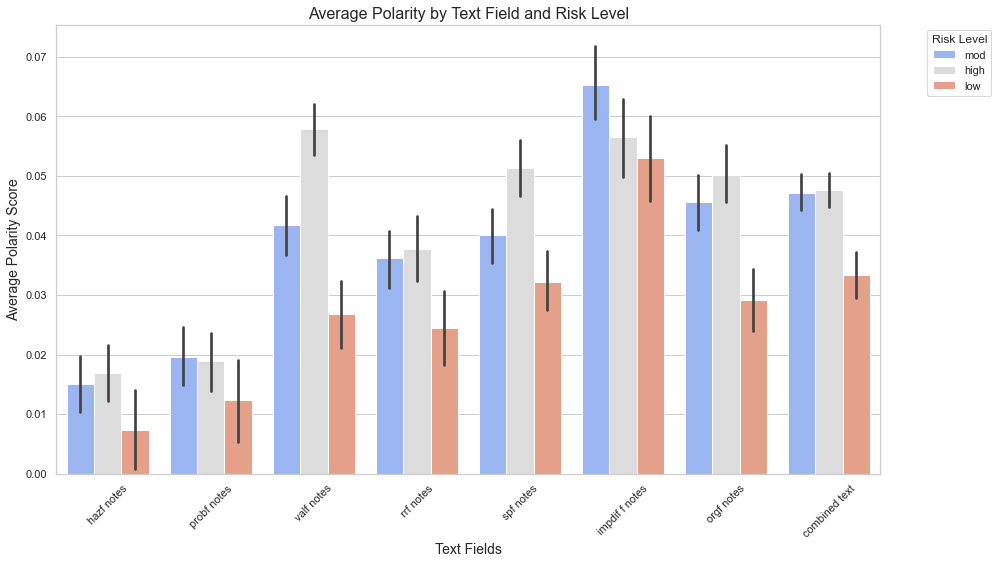

In [58]:
# Melt the DataFrame to have a long format to 
# facilitate the use od Seaborn for clustered bar chart.
melted_data = sent_data.melt(id_vars=['rrf_rr_desc'], 
                             value_vars=polarity_cols, 
                             var_name='Text_Field', 
                             value_name='Average_Polarity')

# Remove the _subjectivity to reduce clutter.
melted_data['Text_Field'] = (
    melted_data['Text_Field']
    .str.replace('_polarity', '')
    .str.replace('_', ' '))

# Plot chart below this cell.
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid")

# Create the bar plot.
ax = sns.barplot(x='Text_Field', 
                 y='Average_Polarity', 
                 hue='rrf_rr_desc', 
                 data=melted_data, 
                 palette="coolwarm")

# Add labels and title.
plt.xlabel('Text Fields', 
           fontsize=14)
plt.ylabel('Average Polarity Score', 
           fontsize=14)
plt.title('Average Polarity by Text Field and Risk Level', 
          fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Risk Level', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left')

plt.tight_layout()
plt.show()

# Risk Classification - Individual Tokens

## Relative Risk Decision and All Text

In this section of the notebook, I explore using the combined text for each fire-risk combination to predict risk. By doing so, I am hopeful that I can gain insight into tokens potentially driving risk decisions. I'll explore different techniques, ensembles, and whatever is necessary to produce the most accurate model.

In [59]:
# Get texts and risks for modeling.
combined_texts = data['combined_text']
risk_labels = data['rrf_rr_desc']

# Check to ensure risk columns have no erroneous entries.
for label in risk_labels:
    if label not in ["high", "mod", "low"]:
        print("Within the data, there is a risk label that is erroneous. "
                "This should be looked into as soon as possible")

# Establish vectorizer.
vectorizer =TfidfVectorizer()

In [60]:
# Create binary data for high vs other risk.
high_other = data.copy()

high_other['rrf_rr_desc'] \
= high_other['rrf_rr_desc'].apply(lambda x: 'other' if x in ['low', 'mod'] else x)

# Get texts and labels for modeling.
high_other_comb_texts = high_other['combined_text']
high_other_labels = high_other['rrf_rr_desc']

### Naive Bayes

#### 3 Risks

In [61]:
# Train and store model and test/train in variables.
nb_classifier, x_nb_train, x_nb_test, \
y_nb_train, y_nb_test = train_nb_classifier(combined_texts,
                                            risk_labels,
                                            .2,
                                            1,
                                            2);

In [62]:
# Predict and measure accuracy.
y_nb_pred = nb_classifier.predict(x_nb_test)
y_nb_train_pred = nb_classifier.predict(x_nb_train)
nb_accuracy = accuracy_score(y_nb_test, y_nb_pred)

# Print accuracy and classification report.
print(f"The Naive Bayes classifier accuracy is {nb_accuracy:.4f} or {nb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_nb_test, y_nb_pred))

The Naive Bayes classifier accuracy is 0.5388 or 53.88%


Classification Report:
              precision    recall  f1-score   support

        high       0.63      0.81      0.71       552
         low       0.56      0.01      0.02       400
         mod       0.46      0.64      0.53       581

    accuracy                           0.54      1533
   macro avg       0.55      0.49      0.42      1533
weighted avg       0.55      0.54      0.46      1533



###### Thoughts

In this three class model, the model performs better than chance guessing. This is a start! However, I am not satisfied with the performance of the model. The macro average of f1-score being .42 is not where I would like it to be by any means. It is interesting thast the model performs significantly better on predicting high risk fires versus low, or moderate risk fires. It is also interesting just how poorly the model performs predicting low risk fires.

#### High vs Mod + Low

In [63]:
# Train again, but this time on the binary high/other data.
honb_classifier, x_honb_train, x_honb_test, \
y_honb_train, y_honb_test \
= train_nb_classifier(high_other_comb_texts, 
                      high_other_labels, 
                      0.2)

In [64]:
# Predict and measure accuracy.
y_honb_pred = honb_classifier.predict(x_honb_test)
y_honb_train_pred = honb_classifier.predict(x_honb_train)
honb_accuracy = accuracy_score(y_honb_test, y_honb_pred)

# Print model accuracy and classification report.
print(
    f"The Naive Bayes classifier accuracy is {honb_accuracy:.4f} "
    f"or {honb_accuracy:.2%}"
)
print("\n")
print("Classification Report:")
print(classification_report(y_honb_test, y_honb_pred))

The Naive Bayes classifier accuracy is 0.6960 or 69.60%


Classification Report:
              precision    recall  f1-score   support

        high       0.84      0.19      0.31       552
       other       0.68      0.98      0.80       981

    accuracy                           0.70      1533
   macro avg       0.76      0.59      0.56      1533
weighted avg       0.74      0.70      0.63      1533



### K Nearest Neighbors

In [65]:
# Ignore a warning that library may change in the future.
warnings.filterwarnings("ignore",
                        category=FutureWarning, 
                        module="sklearn.neighbors._classification")

# Train KNN and store results.
knn_classifier, xnn_train, xnn_test, ynn_train, ynn_test \
    = train_knn_classifier(combined_texts, risk_labels, 6, .2, 2)

In [66]:
# Predict on testing data, calculate accuracy, and print to screen.
knn_pred = knn_classifier.predict(xnn_test)
knn_score = knn_classifier.score(xnn_test,ynn_test)
print(knn_score)

0.3561643835616438


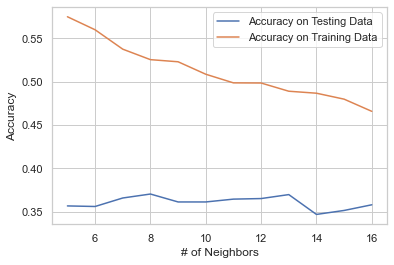

In [67]:
# Use a function to search for ideal number of neighbors.

# Visualize results.
neighbor_number_search(xnn_train,xnn_test,ynn_train,ynn_test,5,17)

###### K Nearest Neighbors Summary

K Nearest Neighbors did not perform particularly well, even on the training data. After attempts at hyperparamater tuning I did not find any further success. With this in mind I am going to move on from attempts modeling with KNN moving forward.

### Penalized Logistic Regression

#### 3 Risks

In [68]:
# Use function to train and store penalized logistic regression model.
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_logistic_reg(combined_texts,
                                         risk_labels,
                                         'l2',
                                         1,
                                         1000)

In [69]:
# Predict and calculate accuracy.
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)

In [70]:
# Print accuracy and classification report.
print(
    f"A penalized logistic regression model classifying risk has "
    f"an accuracy of {plr_score}\n"
)
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.6060013046314416

Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.75      0.72       552
         low       0.64      0.46      0.54       400
         mod       0.51      0.56      0.54       581

    accuracy                           0.61      1533
   macro avg       0.61      0.59      0.60      1533
weighted avg       0.61      0.61      0.60      1533



#### High vs Mod + Low

In [71]:
# Train the same model on the high risk and other risk.
ho_model, ho_lrx_train, ho_lrx_test, ho_lry_train, ho_lry_test \
= train_logistic_reg(high_other_comb_texts, 
                     high_other_labels, 
                     'l2', 
                     1, 
                     1000)

In [72]:
# Predict and calculate accuracy score.
ho_lry_pred = ho_model.predict(ho_lrx_test)
ho_score = accuracy_score(ho_lry_test, ho_lry_pred)

In [73]:
# Print accuracy and classification report.
print(f"The model accuracy is {ho_score}")
print(" \nClassification Report:")
print(classification_report(ho_lry_test, ho_lry_pred))

The model accuracy is 0.7964774951076321
 
Classification Report:
              precision    recall  f1-score   support

        high       0.77      0.62      0.69       552
       other       0.81      0.90      0.85       981

    accuracy                           0.80      1533
   macro avg       0.79      0.76      0.77      1533
weighted avg       0.79      0.80      0.79      1533



### Random Forest 

In [74]:
# Train and store results for a random forest.
rf_classifier,rfx_train, rfx_test, rfy_train, rfy_test\
= train_random_forest(combined_texts,risk_labels)

In [75]:
# Predict and calculate accuracy score.
rfy_pred = rf_classifier.predict(rfx_test)
rf_accuracy = accuracy_score(rfy_test, rfy_pred)
print("Accuracy:", rf_accuracy)

Accuracy: 0.5649054142204827


In [76]:
# Print classification report.
print("Classification Report:\n", classification_report(rfy_test,
                                                        rfy_pred))

Classification Report:
               precision    recall  f1-score   support

        high       0.63      0.78      0.70       552
         low       0.66      0.30      0.41       400
         mod       0.47      0.55      0.51       581

    accuracy                           0.56      1533
   macro avg       0.59      0.54      0.54      1533
weighted avg       0.58      0.56      0.55      1533



Now, I try some hyperparamater tuning to see if model performance can be improved without overfitting.

In [77]:
# Un-comment this code to tune hyperparameters.
# This cell takes hours to run.

#best_rf_classifier, rfx_train, rfx_test, rfy_train, rfy_test \
#= best_random_forest(combined_texts, risk_labels)
#rfy_pred = best_rf_classifier.predict(rfx_test)
#brf_accuracy = accuracy_score(rfy_test, rfy_pred)
#print("Best Model Accuracy:", brf_accuracy)
#print("Best Model Parameters:", best_rf_classifier.get_params())

### Ensemble

In [78]:
# Vectorize and split training data.
x = vectorizer.fit_transform(combined_texts)
y = risk_labels.tolist()

x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 2)

#### Base Models

#####  Naive Bayes

In [79]:
# Train Naive Bayes model for use in stacker.
en_nb_classifier,*_ = train_nb_classifier(combined_texts,
                                          risk_labels,
                                          .2)

# Calculate and display model metrics.
y_pred_nb = en_nb_classifier.predict(x_test)
classification_rep = classification_report(y_test, 
                                           y_pred_nb)
print("Classification Report for Naive Bayes Classifier:")
print(classification_rep)

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

        high       0.63      0.81      0.71       552
         low       0.56      0.01      0.02       400
         mod       0.46      0.64      0.53       581

    accuracy                           0.54      1533
   macro avg       0.55      0.49      0.42      1533
weighted avg       0.55      0.54      0.46      1533



In [80]:
# Train Naive Bayes with optimal alpha value.
en_bestalpha_nb_classifier, *_ = train_nb_classifier(combined_texts,
                                                     risk_labels,
                                                     .2,
                                                     .1)

# Calculate and display results.
y_pred_nb = en_bestalpha_nb_classifier.predict(x_test)
classification_rep = classification_report(y_test, y_pred_nb)
print("Classification Report for Naive Bayes Classifier:")
print(classification_rep)

Classification Report for Naive Bayes Classifier:
              precision    recall  f1-score   support

        high       0.64      0.71      0.67       552
         low       0.58      0.29      0.39       400
         mod       0.47      0.58      0.52       581

    accuracy                           0.55      1533
   macro avg       0.56      0.53      0.53      1533
weighted avg       0.56      0.55      0.54      1533



##### Random Forest

In [81]:
# Train random forest model for use in stacker.
en_rf_classifier, *_ = train_random_forest(combined_texts,
                                           risk_labels,
                                           750) 

###### Penalized Logistic Regression

In [82]:
# Train penalized logistic regression for use in stacker.
en_plr_model, *_ = train_logistic_reg(combined_texts,
                                      risk_labels)

#### Stacker Model

In [83]:
# Define estimators (the models trained above).
estimators = [('PLR',en_plr_model),
              ('RF', en_rf_classifier),
              ('NB', en_nb_classifier),
              ('NB_alpha', en_bestalpha_nb_classifier)]

# Train stacker using estimators and Logistic regression as final estimator.
stacker = StackingClassifier(estimators=estimators,
                             final_estimator=LogisticRegression())

# Fit stacker to training data
stacker.fit(x_train,y_train)

StackingClassifier(estimators=[('PLR',
                                LogisticRegression(C=1, max_iter=500,
                                                   random_state=2)),
                               ('RF',
                                RandomForestClassifier(n_estimators=750,
                                                       random_state=2)),
                               ('NB', MultinomialNB()),
                               ('NB_alpha', MultinomialNB(alpha=0.1))],
                   final_estimator=LogisticRegression())

In [84]:
# Predict on testing data.
stack_pred = stacker.predict(x_test)

# Calculate stacker accuracy.
stack_score = accuracy_score(y_test, stack_pred)

# Output stacker accuracy.
print(stack_score)

0.6353555120678408


### Best Performing Individual Method

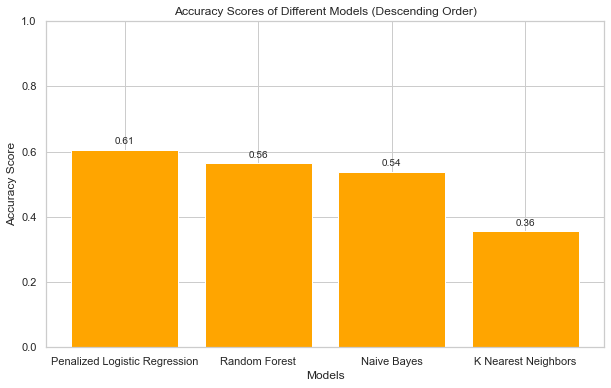

In [85]:
# Store model names and accuracy scores.
model_names = ['Naive Bayes',
               'K Nearest Neighbors',
               'Penalized Logistic Regression',
               'Random Forest']
accuracy_scores = [nb_accuracy, knn_score, plr_score, rf_accuracy]

# Sort both lists in descending order by accuracy score.
sorted_indices = sorted(range(len(accuracy_scores)),
                        key=lambda k: accuracy_scores[k],
                        reverse=True)
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracy_scores = [accuracy_scores[i] for i in sorted_indices]

# Plot accuracy scores for each model.
plt.figure(figsize=(10, 6))
plt.bar(sorted_model_names, sorted_accuracy_scores, color=['orange',
                                                           'orange',
                                                           'orange',
                                                           'orange'])
plt.title('Accuracy Scores of Different Models (Descending Order)')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1) 

for i, v in enumerate(sorted_accuracy_scores):
    plt.text(i, v + 0.01, f'{v:.2f}',
             ha='center',
             va='bottom',
             fontsize=10)

plt.show()

## Relative Risk Decision and rrf_notes

The following is a brief exploration of using only one text field to classify risk decision.

In [86]:
# Use only the desired field as text inputs.
rrf_texts = data['rrf_notes']

In [87]:
# Train logistic regression model and store results.
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_logistic_reg(rrf_texts,
                                         risk_labels,
                                         'l2',
                                         1,
                                         1000)

In [88]:
# Predict on testing data and display results.
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)

# Print results to screen.
print(f"A penalized logistic regression model classifying risk has an accuracy of "
      f"{plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.49510763209393344

Classification Report:
              precision    recall  f1-score   support

        high       0.56      0.60      0.58       552
         low       0.53      0.30      0.39       400
         mod       0.43      0.53      0.47       581

    accuracy                           0.50      1533
   macro avg       0.51      0.48      0.48      1533
weighted avg       0.50      0.50      0.49      1533



In [89]:
# Train Naive Bayes model and store results.
nb_classifier, x_nb_train, x_nb_test, \
y_nb_train, y_nb_test = train_nb_classifier(rrf_texts,
                                            risk_labels,
                                            .2,
                                            1,
                                            2);

In [90]:
# Predict on testing data and calculate accuracy.
y_nb_pred = nb_classifier.predict(x_nb_test)
y_nb_train_pred = nb_classifier.predict(x_nb_train)
nb_accuracy = accuracy_score(y_nb_test, y_nb_pred)

# Print accuracy and classification report.
print(f"The Naive Bayes classifier accuracy is {nb_accuracy:.4f} or "
      f"{nb_accuracy:.2%}")
print("\n")
print("Classification Report:")
print(classification_report(y_nb_test, y_nb_pred))

The Naive Bayes classifier accuracy is 0.4618 or 46.18%


Classification Report:
              precision    recall  f1-score   support

        high       0.48      0.76      0.59       552
         low       0.60      0.07      0.13       400
         mod       0.42      0.45      0.44       581

    accuracy                           0.46      1533
   macro avg       0.50      0.43      0.38      1533
weighted avg       0.49      0.46      0.41      1533



# Risk Classification - N-Grams

## Bigrams

In [92]:
# Set n-grams number to bigrams.
ngram_range = (1, 2)    # You can adjust the n-gram range as needed.

# Vectorize and train/test split text within function.
ng_x_train_tfidf, ng_x_test_tfidf, ng_y_train, ng_y_test \
 = vectorize_text_with_ngrams(combined_texts,
                              risk_labels,
                              ngram_range=ngram_range,
                              test_size=0.2)

In [93]:
# Create naive bayes classifier .
nb_classifier = MultinomialNB()
nb_classifier.fit(ng_x_train_tfidf, ng_y_train)
ng_y_pred = nb_classifier.predict(ng_x_test_tfidf)

# Output results.
accuracy = accuracy_score(ng_y_test, ng_y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(ng_y_test, ng_y_pred))

Accuracy: 0.47423352902804955
Classification Report:
              precision    recall  f1-score   support

        high       0.52      0.90      0.66       552
         low       0.00      0.00      0.00       400
         mod       0.40      0.40      0.40       581

    accuracy                           0.47      1533
   macro avg       0.31      0.43      0.35      1533
weighted avg       0.34      0.47      0.39      1533



In [94]:
# Train logistig regression.
logistic_reg = LogisticRegression(random_state=2)
logistic_reg.fit(ng_x_train_tfidf, ng_y_train)

# Make predictions on the test set.
ng_y_pred = logistic_reg.predict(ng_x_test_tfidf)

# Evaluate the model.
accuracy = accuracy_score(ng_y_test, ng_y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6007827788649707


In [95]:
# Train random forest with n-grams.
ngram_rf = RandomForestClassifier(random_state=2)
ngram_rf.fit(ng_x_train_tfidf,ng_y_train)

# Predict on testing data.
ngram_rf_pred = ngram_rf.predict(ng_x_test_tfidf)

# Evaluate accuracy.
accuracy = accuracy_score(ng_y_test, ngram_rf_pred)

## Trigrams

In [96]:
# Repeat above process with trigrams.
ngram_range = (1, 3)    # Adjust the n-gram range as needed.
trig_x_train_tfidf, trig_x_test_tfidf, trig_y_train, trig_y_test\
= vectorize_text_with_ngrams(combined_texts,
                             risk_labels,
                             ngram_range=ngram_range,
                             test_size=0.2)

In [97]:
# Utilize function to try models and evaluate performance.
results = try_variety_of_models(trig_x_train_tfidf,
                                trig_y_train,
                                trig_x_test_tfidf,
                                trig_y_test)

# Print the results.
for model_name, result in results.items():
    print(f"Results for {model_name}:")
    print("Cross-Validation Scores:", result['Cross-Validation Scores'])
    print("Test Set Classification Report:")
    print(result['Test Set Classification Report'])
    print("\n")

Results for Multinomial Naive Bayes:
Cross-Validation Scores: [0.48899756 0.49796251 0.47879282 0.48205546 0.47960848]
Test Set Classification Report:
              precision    recall  f1-score   support

        high       0.50      0.88      0.64       552
         low       0.00      0.00      0.00       400
         mod       0.39      0.36      0.37       581

    accuracy                           0.46      1533
   macro avg       0.29      0.42      0.34      1533
weighted avg       0.32      0.46      0.37      1533



Results for Logistic Regression:
Cross-Validation Scores: [0.58679707 0.58353708 0.56688418 0.56443719 0.57911909]
Test Set Classification Report:
              precision    recall  f1-score   support

        high       0.64      0.82      0.72       552
         low       0.68      0.34      0.46       400
         mod       0.49      0.52      0.50       581

    accuracy                           0.58      1533
   macro avg       0.60      0.56      0.56    

# SVOs

In [98]:
# Create new column with empty entries.
svo_data = data.copy()
svo_data['combined_text_svo'] = ''

# Iterate through data, extract SVOs, and store in column.
for index, row in svo_data.iterrows():
    text = row['combined_text']
    parsed_text = parser(text)
    svos = findSVOs(parsed_text)
    svo_data.at[index, 'combined_text_svo'] = svos

In [99]:
# Establish texts (SVOs) and labels for modeling.
svos = svo_data['combined_text_svo']
labels = svo_data['rrf_rr_desc']

# Set to string, and seperately store the S, V, and O.
svo_strings = [' '.join(map(str, svo)) for svo in svos]
subjects = [' '.join([svo[0] for svo in svo_pair]) for svo_pair in svos]
verbs = [' '.join([svo[1] for svo in svo_pair]) for svo_pair in svos]
objects = [' '.join([svo[2] for svo in svo_pair]) for svo_pair in svos]

# Ensure consistency in length.
assert len(subjects) == len(labels), "Inconsistent lengths of subjects and labels"

In [100]:
# Iterate through risks and display most common SVOs by risk.
for risk_category in labels.unique():
    print(f"\nTop SVOs for Risk Category: {risk_category}")
    
    # Filter rows for the current risk category.
    rows_for_risk = svo_data[labels == risk_category]
    
    # Flatten the list of SVOs for these rows.
    all_svos = [
        svo 
        for svo_pair in rows_for_risk['combined_text_svo'] 
        for svo in svo_pair
    ]
    
    # Get the most common SVOs and their counts.
    most_common_svos = Counter(all_svos).most_common(5)
    
    # Print the most common SVOs and their counts.
    for svo, count in most_common_svos:
        print(f"{svo}: {count} occurrences")


Top SVOs for Risk Category: mod
('season', 'ending', 'event'): 103 occurrences
('terrain', 'pose', 'problems'): 29 occurrences
('range', 'spotting', 'rates'): 28 occurrences
('barriers', 'spread', 'barriers'): 25 occurrences
('barriers', 'spread', 'fuels'): 19 occurrences

Top SVOs for Risk Category: high
('season', 'ending', 'event'): 135 occurrences
('operations', 'taking', 'place'): 85 occurrences
('range', 'spotting', 'rates'): 52 occurrences
('barriers', 'spread', 'barriers'): 52 occurrences
('action', 'supporting', 'units'): 42 occurrences

Top SVOs for Risk Category: low
('season', 'ending', 'event'): 98 occurrences
('smoke', 'turned', 'unit'): 18 occurrences
('support', 'use', 'role'): 16 occurrences
('barriers', 'spread', 'barriers'): 15 occurrences
('season', 'ending', 'events'): 12 occurrences


In [101]:
# Flatten SVOs.
all_svos = [svo for svo_pair in svos for svo in svo_pair]

# Count occurrences of SVOs.
overall_counts = Counter(all_svos)

# Cutoff for what is considered "disproportionate".
cutoff_threshold = 0.9

# Iterate through unique risk categories.
for risk_category in labels.unique():
    print(f"\nTop Disproportionately Common SVOs for Risk Category: "
      f"{risk_category}")
    
    # Filter rows for the current risk category.
    rows_for_risk = svo_data[labels == risk_category]
    
    # Flatten the list of SVOs for these rows
    svo_counts_for_risk = [svo for svo_pair in rows_for_risk['combined_text_svo'] 
                       for svo in svo_pair]
    
    # Calculate the distribution of SVOs within the current risk category.
    counts_for_risk = Counter(svo_counts_for_risk)
    
    # Calculate the relative frequencies and find disproportionately common SVOs.
    disproportionate_svos = {
        svo: (count / overall_counts[svo]) for svo, count in counts_for_risk.items()
        if overall_counts[svo] > 0 and (count / overall_counts[svo]) <= cutoff_threshold
    }
    
    # Sort and print the most disproportionately common SVOs.
    for svo, relative_frequency in sorted(disproportionate_svos.items(),
                                          key=lambda x: x[1],
                                          reverse=True)[:5]:
        print(f"{svo}: Relative Frequency {relative_frequency:.4f}")


Top Disproportionately Common SVOs for Risk Category: mod
('cooperators', 'neighboring', 'neighbors'): Relative Frequency 0.9000
('frequency', 'iaps', 'issues'): Relative Frequency 0.8750
('activity', 'projected', 'part'): Relative Frequency 0.8750
('smoke', 'reduce', 'infrastructure'): Relative Frequency 0.8750
('number', 'using', 'agency'): Relative Frequency 0.8571

Top Disproportionately Common SVOs for Risk Category: high
('levels', 'varied', 'frequency'): Relative Frequency 0.9000
('effectiveness', 'needed', 'measures'): Relative Frequency 0.9000
('actions', 'required', 'agency'): Relative Frequency 0.9000
('operations', 'taking', 'place'): Relative Frequency 0.8947
('rates', 'spread', 'growth'): Relative Frequency 0.8889

Top Disproportionately Common SVOs for Risk Category: low
('growth', 'remain', 'category'): Relative Frequency 0.8889
('option', 'share', 'managing'): Relative Frequency 0.8750
('discussions', 'taken', 'wildlife'): Relative Frequency 0.8571
('option', 'share',

In [102]:
# Split the data into training and testing sets for subjects.
x_train_sub, x_test_sub, y_train_sub, y_test_sub\
= train_test_split(subjects,
                   labels,
                   test_size=0.2,
                   random_state=2)

# Use TF-IDF vectorization for subjects.
tfidf_vectorizer_sub = TfidfVectorizer()
x_train_tfidf_sub = tfidf_vectorizer_sub.fit_transform(x_train_sub)
x_test_tfidf_sub = tfidf_vectorizer_sub.transform(x_test_sub)

# Create a Logistic Regression model for subjects.
model_sub = LogisticRegression(random_state=2)
model_sub.fit(x_train_tfidf_sub, y_train_sub)
y_pred_sub = model_sub.predict(x_test_tfidf_sub)
accuracy_sub = accuracy_score(y_test_sub, y_pred_sub)
report_sub = classification_report(y_test_sub, y_pred_sub)

# Display evaluation metrics for Subjects.
print("\n### Subjects ###")
print(f"Accuracy: {accuracy_sub:.2f}")
print("Classification Report:\n", report_sub)


# Split the data into training and testing sets for verbs.
x_train_verb, x_test_verb, y_train_verb, y_test_verb = train_test_split(verbs,
                                                                        labels,
                                                                        test_size=0.2,
                                                                        random_state=2)

# Use TF-IDF vectorization for verbs.
tfidf_vectorizer_verb = TfidfVectorizer()
x_train_tfidf_verb = tfidf_vectorizer_verb.fit_transform(x_train_verb)
x_test_tfidf_verb = tfidf_vectorizer_verb.transform(x_test_verb)

# Create a Logistic Regression model for verbs.
model_verb = LogisticRegression(random_state=2)
model_verb.fit(x_train_tfidf_verb, y_train_verb)
y_pred_verb = model_verb.predict(x_test_tfidf_verb)
accuracy_verb = accuracy_score(y_test_verb, y_pred_verb)
report_verb = classification_report(y_test_verb, y_pred_verb)

# Display evaluation metrics for Verbs.
print("\n### Verbs ###")
print(f"Accuracy: {accuracy_verb:.2f}")
print("Classification Report:\n", report_verb)


# Split the data into training and testing sets for objects.
x_train_obj, x_test_obj, y_train_obj, y_test_obj = train_test_split(objects,
                                                                    labels,
                                                                    test_size=0.2,
                                                                    random_state=2)

# Use TF-IDF vectorization for objects.
tfidf_vectorizer_obj = TfidfVectorizer()
x_train_tfidf_obj = tfidf_vectorizer_obj.fit_transform(x_train_obj)
x_test_tfidf_obj = tfidf_vectorizer_obj.transform(x_test_obj)

# Create a Logistic Regression model for objects.
model_obj = LogisticRegression(random_state=2)
model_obj.fit(x_train_tfidf_obj, y_train_obj)
y_pred_obj = model_obj.predict(x_test_tfidf_obj)
accuracy_obj = accuracy_score(y_test_obj, y_pred_obj)
report_obj = classification_report(y_test_obj, y_pred_obj)

# Display evaluation metrics for Objects.
print("\n### Objects ###")
print(f"Accuracy: {accuracy_obj:.2f}")
print("Classification Report:\n", report_obj)


### Subjects ###
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

        high       0.52      0.57      0.54       552
         low       0.39      0.23      0.29       400
         mod       0.42      0.50      0.45       581

    accuracy                           0.45      1533
   macro avg       0.44      0.43      0.43      1533
weighted avg       0.45      0.45      0.44      1533


### Verbs ###
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

        high       0.50      0.55      0.52       552
         low       0.43      0.24      0.31       400
         mod       0.40      0.49      0.44       581

    accuracy                           0.45      1533
   macro avg       0.44      0.43      0.42      1533
weighted avg       0.45      0.45      0.44      1533


### Objects ###
Accuracy: 0.45
Classification Report:
               precision    recall  f1-score   support

        high    

In [103]:
# Train/test split SVO data.
x_train, x_test, y_train, y_test = train_test_split(svo_strings,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=2)

# Vectorize SVOs.
tfidf_vectorizer = TfidfVectorizer()
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

In [104]:
# Fit Random Forest model.
model = RandomForestClassifier()
model.fit(x_train_tfidf, y_train)

# Predict and calculate accuracy.
y_pred = model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)

# Print accuracy and classification report.
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

        high       0.54      0.64      0.59       552
         low       0.55      0.23      0.32       400
         mod       0.42      0.52      0.47       581

    accuracy                           0.49      1533
   macro avg       0.51      0.46      0.46      1533
weighted avg       0.50      0.49      0.47      1533



# Final Model and Insights

## Best Individual Model - Penalized Logistic Regression

The following is the best indivudual model found during this project, and an examination of the text features that drive the risk predictions.

In [105]:
# Train and store model variables.
plr_model, lrx_train, lrx_test,\
lry_train, lry_test = train_logistic_reg(combined_texts,
                                         risk_labels,
                                         'l2',
                                         1.1,
                                         1000)

# Predict and measure accuracy.
lry_pred = plr_model.predict(lrx_test)
plr_score = accuracy_score(lry_test, lry_pred)

# Print accuracy and classification report.
print(f"A penalized logistic regression model classifying risk has an accuracy of "
      f"{plr_score}\n")
print("Classification Report:")
print(classification_report(lry_test, lry_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.6033920417482062

Classification Report:
              precision    recall  f1-score   support

        high       0.69      0.75      0.72       552
         low       0.62      0.46      0.53       400
         mod       0.51      0.56      0.53       581

    accuracy                           0.60      1533
   macro avg       0.61      0.59      0.60      1533
weighted avg       0.61      0.60      0.60      1533



###### Power BI Export

In [106]:
# Store classification report in dict.
report_dict = classification_report(lry_test,
                                    lry_pred,
                                    output_dict=True)

# Convert the classification report dictionary into a DataFrame.
report_df = pd.DataFrame(report_dict).transpose()
report_df.reset_index(inplace=True)

# Rename the 'index' column to whatever you prefer.
report_df.rename(columns={'index': 'metrics'}, inplace=True)

# Add a new row for the model accuracy at the end of the DataFrame.
accuracy_row = pd.DataFrame({'precision': [None],
                             'recall': [None],
                             'f1-score': [ho_score_high_risk],
                             'support': [None]},
                            index=['accuracy'])

# Append the accuracy row to the report DataFrame
final_report_df4 = pd.concat([report_df, accuracy_row])

# Export to .csv for use in Power BI
final_report_df4.to_csv("threeclassreport.csv")

### Insights

In [107]:
# Pull text features from model.
feature_names = vectorizer.get_feature_names_out()

# Pull feature coefficients from model.
coefficients = plr_model.coef_

# Pull highest coefficient features for each risk in the data.
num_top_features = 20
for class_index, class_name in enumerate(plr_model.classes_):

    # Retrieve coefficients for current class.
    class_coefficients = coefficients[class_index]
    
    # Sort coefficients descending and select corresponding features.
    top_feature_indices = np.argsort(class_coefficients)[-num_top_features:][::-1]
    top_features = [feature_names[i] for i in top_feature_indices]

    # Output top feature-coefficient pairs.
    print(f"Top features for class '{class_name}':")
    for feature in top_features:
        coefficient_value = class_coefficients[np.where(feature_names
                                                        == feature)[0][0]]
        print(f"- {feature}: {coefficient_value:.4f}")
    print("\n")


Top features for class 'high':
- extreme: 3.9464
- dry: 2.6941
- structures: 2.3348
- difficult: 2.0321
- large: 1.9933
- continuous: 1.9717
- team: 1.9574
- record: 1.7920
- state: 1.7695
- homes: 1.7367
- availability: 1.7285
- spotting: 1.7110
- imt: 1.6947
- crown: 1.6884
- long: 1.6599
- throughout: 1.6411
- evacuations: 1.5379
- drought: 1.5169
- communities: 1.5147
- private: 1.4996


Top features for class 'low':
- minimal: 3.2678
- monitor: 2.3398
- precipitation: 2.2201
- sparse: 1.9610
- monitoring: 1.9457
- surrounded: 1.9362
- little: 1.9046
- late: 1.8475
- fall: 1.8441
- reduced: 1.7946
- smoldering: 1.7719
- contained: 1.7648
- repair: 1.7197
- monitored: 1.6926
- snow: 1.6850
- rain: 1.6716
- moisture: 1.6268
- elevation: 1.6131
- received: 1.6087
- monsoonal: 1.5831


Top features for class 'mod':
- still: 1.6637
- consists: 1.4142
- scars: 1.3709
- average: 1.2759
- away: 1.1493
- vegetation: 1.1411
- solely: 1.0872
- mitigated: 1.0593
- sufficient: 1.0435
- adequate

In [108]:
# Store information in .csv.
store_coefficients(vectorizer = vectorizer,
                   plr_model = plr_model,
                   num_features = 8)

## Best Ensemble - Stacker

In [109]:
# Train NB classifier.
best_nb_classifier, *_ = train_nb_classifier(combined_texts,
                                             risk_labels,
                                             .2,
                                             .1)

In [110]:
# Define estimators.
estimators = [('PLR',plr_model),
              ('RF', en_rf_classifier),
              ('NB_alpha', best_nb_classifier)]

In [111]:
# Initialize and train stacker model.
stacker = StackingClassifier(estimators=estimators,
                             final_estimator=LogisticRegression())
stacker.fit(lrx_train,lry_train)
;

''

In [112]:
# Predict on testing and calculate accuracy.
stack_pred = stacker.predict(lrx_test)
stack_score = accuracy_score(lry_test, stack_pred)

# Print accuracy.
print(stack_score)

0.6333985649054142


# How Does Text Change Across Agency Involvement?

In [8]:
# Establish list of agencies.
agencies = ['usfs',
            'ancsa',
            'blm',
            'bia_tribal',
            'c_l',
            'nps',
            'other',
            'state',
            'usfws',
            'doi',
            'federal']

In [9]:
# Create data copy.
data_copy = data.copy()

In [10]:
# Run function to examine agency involvement and store results.
agency_involvement = analyze_agency_involvement(data_copy,
                                                agencies)
agency_involvement;

## Overview Data

###### Percentage Involvement

The below chart visualizes the percentage of risk-report entries that have a positive value for a given agencies involvement. It is noteworthy that 98% of fires have some amount of federal involvement. Roughly two-thirds of fires have U.S. Forest Service (USFS) involvement, and roughly half have Department of The Interior (DOI) involvement. The other agencies have a much smaller share of reports, ranging from roughly 3% to roughly 33% of fire-risk combinations.

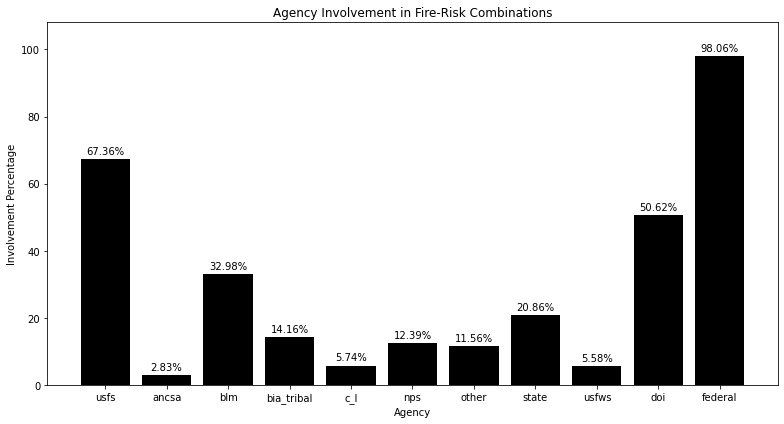

In [11]:
# Extract and store agency and involvement percentage pairs.
involvement_percentages = {agency: data['involvement_percentage'] 
                           for agency, data in agency_involvement.items()}
agencies = list(involvement_percentages.keys())
percentages = list(involvement_percentages.values())

# Plot agency involvement.
fig, ax = plt.subplots(figsize=(11, 6))
bars = ax.bar(agencies, percentages,
              color='#000000')

# Add labels and title.
ax.set_xlabel('Agency')
ax.set_ylabel('Involvement Percentage')
ax.set_title('Agency Involvement in Fire-Risk Combinations')
ax.set_ylim(0, max(percentages) + 10)  

# Add percentage labels above bars.
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')
    
plt.tight_layout()
plt.show()

###### Prediction Accuracy

The below chart plots the accuracy of a logistic regression model at predicting whether or not an agency is involved in a fire report using the text for a fire. This was fairly succesful! The model predicts at between 79% and 98% accuracy across agencies. Later, we will use the feature-coefficient pairings to determine the features that are potentially predictive of agency involvement in a given fire.

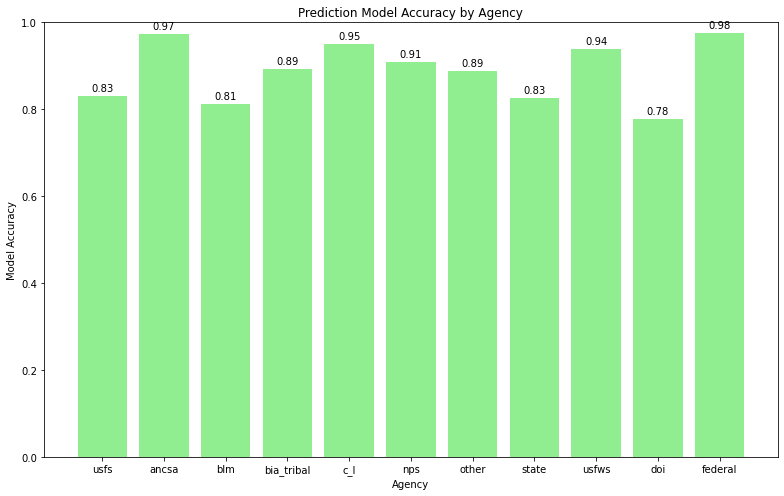

In [12]:
# Pull agency and prediction accuracy and store in lists.
model_accuracies = {agency: data['model_performance']['accuracy']
                    for agency, data in agency_involvement.items()}
agencies = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Creating a bar chart for model accuracies.
fig, ax = plt.subplots(figsize=(11,7))
bars = ax.bar(agencies, accuracies, color='lightgreen')

# Adding labels and title.
ax.set_xlabel('Agency')
ax.set_ylabel('Model Accuracy')
ax.set_title('Prediction Model Accuracy by Agency')
ax.set_ylim(0, 1)  # Accuracy range is 0 to 1.

# Adding accuracy labels above bars.
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

###### Multi-Jurisdictional Fires

In the cell below, the percentage of fires that are multi-jurisdictional (defined here as having involvement from more than one agency). This is the vast majority of fires.

In [13]:
# Determine number of reports classified as multi-jurisdictional in reports.
data['multi-jurisdictional'] = data.apply(
    lambda row: 1 if sum(row[col] >= 1 for col in ['usfs', 
                                                   'ancsa', 
                                                   'blm', 
                                                   'bia_tribal', 
                                                   'c_l', 
                                                   'nps', 
                                                   'other', 
                                                   'state', 
                                                   'usfws', 
                                                   'doi', 
                                                   'federal']) > 1 else 0, axis=1)

# Calculate percentage and output to screen.
percentage_multi_jurisdictional = (data['multi-jurisdictional'].sum()
                                   / len(data)) * 100
print(f"{percentage_multi_jurisdictional}")

98.52576647097196


## Agency Specific Insights

In [14]:
# Establish defaultdict.
flattened_data = defaultdict(list)

# Convert results dict to a dataframe for ease of analysis.
for key, value in agency_involvement.items():
    # Initialize/reset a temporary dictionary for the current row.
    temp_dict = defaultdict(list)
    
    # Assign the agency name for the current row.
    temp_dict['agency'] = [key]
    
    # Iterate through the nested dictionaries.
    for sub_key, sub_value in value.items():
        if isinstance(sub_value, dict):
            for sub_sub_key, sub_sub_value in sub_value.items():
                if isinstance(sub_sub_value, list):
                    temp_dict[sub_sub_key].append(sub_sub_value)
                else:
                    temp_dict[sub_sub_key].append(sub_sub_value)
        else:
            temp_dict[sub_key].append(sub_value)
    
    # Merge temp_dict into flattened_data, ensuring each key gets its corresponding value.
    for temp_key, temp_value in temp_dict.items():
        flattened_data[temp_key].extend(temp_value)

# Convert the flattened dictionary to a DataFrame.
flat = pd.DataFrame(flattened_data)

# Convert agency column to string.
flat['agency'] = flat['agency'].astype(str)

### National Park Service

In [15]:
# Use a function to generate agency-specific stats for NPS.
nps_results = get_agency_stats(flat,'nps')
pretty_print_results(nps_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 12.39
common_words_present      :
[   ('fuel', 1729),
    ('fuels', 1443),
    ('behavior', 1395),
    ('spread', 1394),
    ('season', 1195),
    ('growth', 1181),
    ('smoke', 1175),
    ('barriers', 1087),
    ('conditions', 1061),
    ('time', 1024)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10686),
    ('fuels', 8713),
    ('private', 8395),
    ('spread', 7679),
    ('season', 7304),
    ('behavior', 7177),
    ('incident', 6421),
    ('time', 6378),
    ('conditions', 6211),
    ('barriers', 6013)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08569851781772311,
    'behavior': 0.10998107852412488,
    'conditions': 0.08364869126458531,
    'fuel': 0.13631346578366446,
    'fuels': 0.11376537369914853,
    'growth': 0.09310942920214443,
    'se

In [16]:
# Address class imbalance using function and model.
adress_agency_imbalance('nps', data_copy)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1372
           1       0.96      0.96      0.96      1314

    accuracy                           0.96      2686
   macro avg       0.96      0.96      0.96      2686
weighted avg       0.96      0.96      0.96      2686

Cross-validated scores: [0.94601638 0.93670886 0.94973939 0.95830231 0.9530901 ]
Mean accuracy: 0.948771407297096

Sorted positive class feature coefficients:
park: 12.59553602148231
nps: 10.229304246532692
lava: 4.578711603801073
yosemite: 3.467403787244859
yellowstone: 3.0692454713360173
grand: 2.9833432914238665
levels: 2.9763700004940588
preserve: 2.761047392533665
tioga: 2.4630534825598853
crater: 2.4273469020991505
jurisdictions: 2.422413621635002
cabin: 2.368205038030776

Sorted negative class feature coefficients:
timber: -4.0676165960778325
private: -3.2883052259857943
hunting: -2.9450398046242485
type: -2.7994652757332927
suppression: -2.0055540678688013


### ANCSA

In [17]:
# Use a function to generate agency-specific stats for ANCSA.
ancsa_results = get_agency_stats(flat,'ancsa')
pretty_print_results(ancsa_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 2.83
common_words_present      :
[   ('native', 463),
    ('spread', 358),
    ('protection', 358),
    ('allotments', 335),
    ('conditions', 333),
    ('fuels', 326),
    ('weather', 304),
    ('smoke', 261),
    ('behavior', 261),
    ('season', 259)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 12185),
    ('fuels', 9830),
    ('private', 9247),
    ('spread', 8715),
    ('behavior', 8311),
    ('season', 8240),
    ('time', 7224),
    ('incident', 7125),
    ('conditions', 6939),
    ('barriers', 6910)]
--------------------------------------------------
relative_freq_present     :
{   'allotments': 0.10282381829343155,
    'behavior': 0.08011049723756906,
    'conditions': 0.10220994475138122,
    'fuels': 0.10006138735420503,
    'native': 0.14211172498465316,
    'protection': 0.10988336402701043,

### Bureau of Land Management

In [18]:
# Use a function to generate agency-specific stats for BLM.
blm_results = get_agency_stats(flat,'blm')
pretty_print_results(blm_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 32.98
common_words_present      :
[   ('fuel', 4992),
    ('private', 4345),
    ('fuels', 4026),
    ('spread', 3519),
    ('suppression', 3304),
    ('behavior', 3139),
    ('incident', 3053),
    ('season', 3007),
    ('conditions', 2838),
    ('time', 2827)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 7423),
    ('fuels', 6130),
    ('spread', 5554),
    ('season', 5492),
    ('behavior', 5433),
    ('private', 4981),
    ('time', 4575),
    ('barriers', 4528),
    ('conditions', 4434),
    ('smoke', 4377)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.08955777460770328,
    'conditions': 0.08097004279600571,
    'fuel': 0.14242510699001426,
    'fuels': 0.1148644793152639,
    'incident': 0.08710413694721826,
    'private': 0.12396576319543509,
    

In [19]:
# Address agency imbalance and display results.
adress_agency_imbalance('blm', data_copy)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       971
           1       0.87      0.83      0.85      1084

    accuracy                           0.84      2055
   macro avg       0.84      0.85      0.84      2055
weighted avg       0.85      0.84      0.84      2055

Cross-validated scores: [0.8189781  0.80291971 0.83065693 0.85790754 0.83106134]
Mean accuracy: 0.8283047261648389

Sorted positive class feature coefficients:
blm: 10.309739542056896
sage: 3.4079311110197814
grouse: 2.957700432701082
structures: 2.7908112675773817
sage grouse: 2.6500213431939326
agencies: 2.64260550266791
habitat: 2.5852692803074975
grazing: 2.5813577979626126
priority: 2.5121383825729926
suppression: 2.504439085165182
jurisdictions: 2.406851476141229
evacuations: 2.2912433247388724

Sorted negative class feature coefficients:
smoke: -3.1809571855203553
fs: -2.2733563392523943
surrounded: -2.1053614769669657
manage: -2.054061684456101
wilderness: 

In [20]:
# Look at risk percentages when BLM is involved.

# Filter data to only BLM fires.
filtered_data = data_copy[data_copy['blm'] == 1]

# Calculate percentage of each unique level in 'rrf_rr_desc' column.
percentage_per_level = filtered_data['rrf_rr_desc'].value_counts(
    normalize=True) * 100

# Print results.
print(percentage_per_level)

rrf_rr_desc
high    52.492089
mod     32.080696
low     15.427215
Name: proportion, dtype: float64


### Bureau of Indian Affairs - Tribal

In [21]:
# Use a function to generate agency-specific stats for bia_tribal.
biat_results = get_agency_stats(flat,'bia_tribal')
pretty_print_results(biat_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 14.16
common_words_present      :
[   ('fuel', 1965),
    ('fuels', 1762),
    ('suppression', 1550),
    ('spread', 1500),
    ('conditions', 1424),
    ('behavior', 1402),
    ('season', 1339),
    ('weather', 1319),
    ('incident', 1245),
    ('private', 1216)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10450),
    ('fuels', 8394),
    ('private', 8110),
    ('spread', 7573),
    ('behavior', 7170),
    ('season', 7160),
    ('time', 6366),
    ('incident', 6125),
    ('barriers', 6063),
    ('conditions', 5848)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.09523162613775302,
    'conditions': 0.09672598831680478,
    'fuel': 0.1334737128107594,
    'fuels': 0.11968482543132726,
    'incident': 0.08456731422361093,
    'private': 0.0825974731694063

### C_L

In [22]:
# Use a function to generate agency-specific stats for c_l.
cl_results = get_agency_stats(flat,'c_l')
pretty_print_results(cl_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 5.74
common_words_present      :
[   ('fuel', 776),
    ('private', 712),
    ('fuels', 579),
    ('suppression', 570),
    ('behavior', 534),
    ('spread', 482),
    ('incident', 456),
    ('type', 441),
    ('weather', 434),
    ('barriers', 427)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 11639),
    ('fuels', 9577),
    ('private', 8614),
    ('spread', 8591),
    ('season', 8160),
    ('behavior', 8038),
    ('time', 7039),
    ('incident', 6914),
    ('conditions', 6877),
    ('barriers', 6673)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.07891332470892626,
    'behavior': 0.09868785806690075,
    'fuel': 0.14341156902605803,
    'fuels': 0.10700425060062835,
    'incident': 0.08427277767510627,
    'private': 0.13158381075586767,
    'spread':

### State Agencies

In [23]:
# Use a function to generate agency-specific stats for state.
st_results = get_agency_stats(flat,'state')
pretty_print_results(st_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 20.86
common_words_present      :
[   ('fuel', 3239),
    ('fuels', 2826),
    ('private', 2636),
    ('spread', 2351),
    ('season', 2305),
    ('suppression', 2303),
    ('behavior', 2200),
    ('incident', 2126),
    ('conditions', 2038),
    ('weather', 1956)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 9176),
    ('fuels', 7330),
    ('spread', 6722),
    ('private', 6690),
    ('behavior', 6372),
    ('season', 6194),
    ('time', 5491),
    ('barriers', 5310),
    ('incident', 5244),
    ('conditions', 5234)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.09174311926605505,
    'conditions': 0.08498748957464554,
    'fuel': 0.13507089241034195,
    'fuels': 0.11784820683903252,
    'incident': 0.08865721434528774,
    'private': 0.1099249374478732

### U.S. Fish and Wildlife Service

In [24]:
# Use a function to generate agency-specific stats for usfws.
usfws_results = get_agency_stats(flat,'usfws')
pretty_print_results(usfws_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 5.58
common_words_present      :
[   ('spread', 780),
    ('fuel', 720),
    ('fuels', 676),
    ('objectives', 560),
    ('behavior', 550),
    ('suppression', 546),
    ('season', 542),
    ('conditions', 521),
    ('smoke', 502),
    ('incident', 498)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 11695),
    ('fuels', 9480),
    ('private', 8832),
    ('spread', 8293),
    ('behavior', 8022),
    ('season', 7957),
    ('time', 6942),
    ('incident', 6872),
    ('conditions', 6751),
    ('barriers', 6642)]
--------------------------------------------------
relative_freq_present     :
{   'behavior': 0.09329940627650551,
    'conditions': 0.08837998303647158,
    'fuel': 0.12213740458015267,
    'fuels': 0.11467345207803223,
    'incident': 0.08447837150127227,
    'objectives': 0.09499575911789652,
   

In [25]:
adress_agency_imbalance('usfws',data_copy)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1448
           1       0.96      0.98      0.97      1447

    accuracy                           0.97      2895
   macro avg       0.97      0.97      0.97      2895
weighted avg       0.97      0.97      0.97      2895

Cross-validated scores: [0.9492228  0.96856649 0.96614853 0.9775475  0.96717346]
Mean accuracy: 0.965731756370455

Sorted positive class feature coefficients:
refuge: 9.222564452330243
fws: 6.068911499859465
usfws: 5.0473337446274975
allotments: 4.320606729171035
native: 4.12710973827926
organic: 3.0643215983282723
twisp: 3.050685766402556
marsh: 2.9799025710308564
columbia: 2.608953288470175
sterling: 2.450367612746747
water: 2.4211274186285463
team appropriate: 2.3869211612500747

Sorted negative class feature coefficients:
single: -2.710209328996163
monsoonal: -2.4455468889516148
ercs: -2.4063570978444764
steep: -2.3219851679049515
monsoon: -2.2931642160239605
m

### Department of The Interior

In [26]:
# Use a function to generate agency-specific stats for doi.
doi_results = get_agency_stats(flat,'doi')
pretty_print_results(nps_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 12.39
common_words_present      :
[   ('fuel', 1729),
    ('fuels', 1443),
    ('behavior', 1395),
    ('spread', 1394),
    ('season', 1195),
    ('growth', 1181),
    ('smoke', 1175),
    ('barriers', 1087),
    ('conditions', 1061),
    ('time', 1024)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10686),
    ('fuels', 8713),
    ('private', 8395),
    ('spread', 7679),
    ('season', 7304),
    ('behavior', 7177),
    ('incident', 6421),
    ('time', 6378),
    ('conditions', 6211),
    ('barriers', 6013)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08569851781772311,
    'behavior': 0.10998107852412488,
    'conditions': 0.08364869126458531,
    'fuel': 0.13631346578366446,
    'fuels': 0.11376537369914853,
    'growth': 0.09310942920214443,
    'se

### Federal

In [27]:
# Use a function to generate agency-specific stats for fed.
fed_results = get_agency_stats(flat,'federal')
pretty_print_results(fed_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 98.06
common_words_present      :
[   ('fuel', 12290),
    ('fuels', 10028),
    ('private', 9235),
    ('spread', 8960),
    ('behavior', 8485),
    ('season', 8404),
    ('time', 7318),
    ('incident', 7256),
    ('conditions', 7167),
    ('barriers', 7025)]
--------------------------------------------------
common_words_absent       :
[   ('fuels', 128),
    ('fuel', 125),
    ('incident', 114),
    ('spread', 113),
    ('conditions', 105),
    ('season', 95),
    ('private', 91),
    ('suppression', 87),
    ('behavior', 87),
    ('time', 84)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.08152678488534026,
    'behavior': 0.0984704298579519,
    'conditions': 0.083174728437471,
    'fuel': 0.14262835391328568,
    'fuels': 0.11637730944202024,
    'incident': 0.08420759446662333,
    'private': 

### Other Agencies

In [28]:
# Use a function to generate agency-specific stats for other.
other_results = get_agency_stats(flat,'other')
pretty_print_results(other_results)

Agency Stats Overview:

Metric                    | Value
--------------------------------------------------
involvement_percentage    | 11.56
common_words_present      :
[   ('fuel', 1435),
    ('private', 1393),
    ('fuels', 1144),
    ('spread', 1025),
    ('suppression', 1009),
    ('incident', 899),
    ('behavior', 862),
    ('season', 825),
    ('objectives', 822),
    ('barriers', 812)]
--------------------------------------------------
common_words_absent       :
[   ('fuel', 10980),
    ('fuels', 9012),
    ('spread', 8048),
    ('private', 7933),
    ('behavior', 7710),
    ('season', 7674),
    ('time', 6727),
    ('conditions', 6473),
    ('incident', 6471),
    ('barriers', 6288)]
--------------------------------------------------
relative_freq_present     :
{   'barriers': 0.07940543712106396,
    'behavior': 0.08429493448073538,
    'fuel': 0.14032857422256992,
    'fuels': 0.11187169958928223,
    'incident': 0.08791316252689224,
    'objectives': 0.08038333659299823,

## Visual Product Files

In [29]:
# Iterate through agencies and store results in a .csv for use in Power BI.
for agency in agencies:
    update_agency_stats_and_features(agency, data_copy)

Updated statistics for usfs saved to agency_stats.csv.
Feature coefficients for usfs saved to agency_features.csv.
Updated statistics for ancsa saved to agency_stats.csv.
Feature coefficients for ancsa saved to agency_features.csv.
Updated statistics for blm saved to agency_stats.csv.
Feature coefficients for blm saved to agency_features.csv.
Updated statistics for bia_tribal saved to agency_stats.csv.
Feature coefficients for bia_tribal saved to agency_features.csv.
Updated statistics for c_l saved to agency_stats.csv.
Feature coefficients for c_l saved to agency_features.csv.
Updated statistics for nps saved to agency_stats.csv.
Feature coefficients for nps saved to agency_features.csv.
Updated statistics for other saved to agency_stats.csv.
Feature coefficients for other saved to agency_features.csv.
Updated statistics for state saved to agency_stats.csv.
Feature coefficients for state saved to agency_features.csv.
Updated statistics for usfws saved to agency_stats.csv.
Feature coef

# Acreage and Text

## Overview

### Distribution

Text(0.5, 1.0, 'Distribution of Acreage')

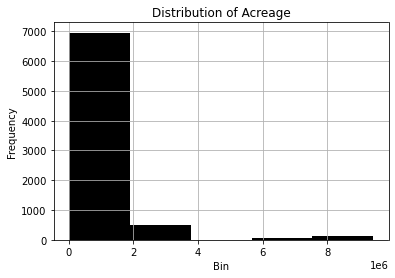

In [30]:
# Create visualization of acreage distribution.
data['acreage'].hist(bins=5, color='black')

# add labels and title.
plt.xlabel('Bin')
plt.ylabel('Frequency')
plt.title('Distribution of Acreage')

In [31]:
# Find percentile marks in data.
percentiles = [25, 50, 75, 90, 95]
percentile_values = np.percentile(data['acreage'].dropna(), percentiles)

# Display the calculated percentiles.
percentile_dict = {f"{p}th percentile": value for p, value in zip(percentiles, percentile_values)}
percentile_dict

{'25th percentile': 28460.0,
 '50th percentile': 99428.0,
 '75th percentile': 531325.0,
 '90th percentile': 1347644.0,
 '95th percentile': 2358084.0}

### PCA

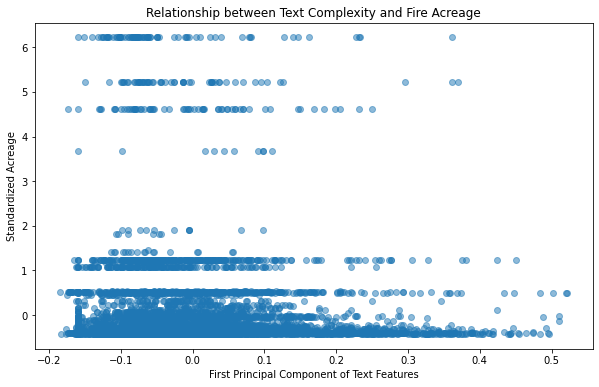

In [35]:
# Vectorize text.
tfidf_matrix = vectorizer.fit_transform(data['combined_text'].fillna(''))

# Establish quick PCA.
pca = PCA(n_components=1)
tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

# Standardize acreage for better visualization.
scaler = StandardScaler()
acreage_scaled = scaler.fit_transform(data[['acreage']])

# Plot PCA.
plt.figure(figsize=(10, 6))
plt.scatter(tfidf_pca, acreage_scaled, alpha=0.5)
plt.xlabel('First Principal Component of Text Features')
plt.ylabel('Standardized Acreage')
plt.title('Relationship between Text Complexity and Fire Acreage')
plt.show()

## Analysis

In [36]:
# Bin data to quartiles.
percentile_thresholds = np.percentile(data['acreage'], [25, 50, 75])
firebins = [0] + list(percentile_thresholds) + [data['acreage'].max()]
size_labels = ['very_small', 'small', 'medium', 'large']

# Establish new column with the corresponding bin of the report
data['size_cat'] = pd.cut(data['acreage'], bins=firebins, \
                   labels=size_labels, include_lowest=True)

### Suppression & Containment

In [37]:
# Create binary columns for mention of suppression and containment.
data['mentions_suppression'] = data['combined_text'].str.contains\
                            ('suppression', case=False, na=False).astype(int)
data['mentions_containment'] = data['combined_text'].str.contains\
                            ('containment', case=False, na=False).astype(int)

In [38]:
# Calculate percentage of reports containing each.
token_presence_by_size = data.groupby('size_cat')[
    ['mentions_suppression', 'mentions_containment']].mean()

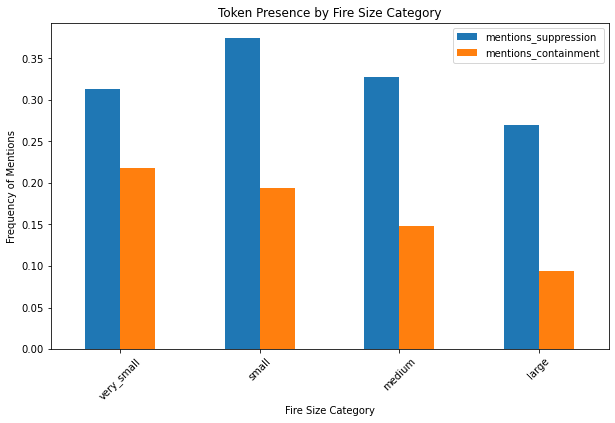

In [39]:
# Plot percentages.
token_presence_by_size.plot(kind='bar', figsize=(10, 6), 
                            title="Token Presence by Fire Size Category")
plt.xlabel('Fire Size Category')
plt.ylabel('Frequency of Mentions')
plt.xticks(rotation=45)
plt.show()

### Text Differences By Size

Overall, the text between acreage bins is incredibly similar. The lowest similarity score is between "very_small" and "large", and the highest is between "very_small" and "small". This is intuitive, but not all that much of a difference. Since all cosine similarity scores are close to 1, we can interpret that the language used in reports is quite similar across acreage bins. 

While the difference is slight, it is worth exploring the difference in language between a "very_small" and "large" fire report. It is worth noting that scores are symmetric, and no difference would be found between the score of "very_small" and "small" versus "small" and "very_small". TO avoid clutter, I did not print reduntant scores.

In [40]:
warnings.filterwarnings('ignore', category=FutureWarning)

# Vectorize text.
tfidf_matrix = vectorizer.fit_transform(data['combined_text'])

# Store average vectors.
average_vectors = {}
for bin_label in size_labels:
    indices = data[data['size_cat'] == bin_label].index
    average_vectors[bin_label] = average_tfidf_vectors(tfidf_matrix, indices)

# Initialize empty dictionary.
cosine_similarities = {}

# Calculate and store cosine similarities.
for bin_label_1 in size_labels:
    for bin_label_2 in size_labels:
        if bin_label_1 != bin_label_2:
            # Compute cosine similarity between the average vectors of two different bins.
            sim = cosine_similarity(average_vectors[bin_label_1].reshape(1, -1), 
                                    average_vectors[bin_label_2].reshape(1, -1))[0][0]
            cosine_similarities[(bin_label_1, bin_label_2)] = sim

# Print the cosine similarities without reduntant output.
printed_scores = set()

# Output cosine similarities between bins.
for bins, similarity in cosine_similarities.items():
    bins_tuple = tuple(sorted(bins))
    if bins_tuple not in printed_scores:
        print(f"Cosine similarity between {bins[0]} and {bins[1]}: {similarity}")
        printed_scores.add(bins_tuple)
    
warnings.resetwarnings()

Cosine similarity between very_small and small: 0.973437548010656
Cosine similarity between very_small and medium: 0.9631495620971391
Cosine similarity between very_small and large: 0.8956547732797653
Cosine similarity between small and medium: 0.9707572607183746
Cosine similarity between small and large: 0.902368391976925
Cosine similarity between medium and large: 0.9243229658344538


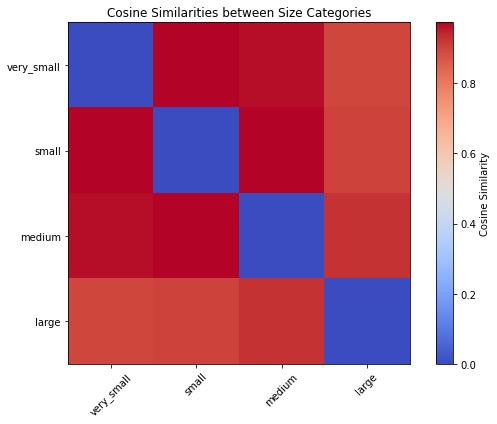

In [41]:
# Create heatmap of cosine similarities.
labels = size_labels
num_labels = len(labels)
cosine_matrix = np.zeros((num_labels, num_labels))

for bins, similarity in cosine_similarities.items():
    label_1_idx = labels.index(bins[0])
    label_2_idx = labels.index(bins[1])
    cosine_matrix[label_1_idx, label_2_idx] = similarity

# Plotting heatmap
plt.figure(figsize=(8, 6))
plt.imshow(cosine_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Cosine Similarities between Size Categories')
plt.colorbar(label='Cosine Similarity')
plt.xticks(np.arange(num_labels), labels, rotation=45)
plt.yticks(np.arange(num_labels), labels)
plt.tight_layout()
plt.show()

C:\Users\aidan\anaconda3\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
C:\Users\aidan\anaconda3\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 720x576 with 0 Axes>

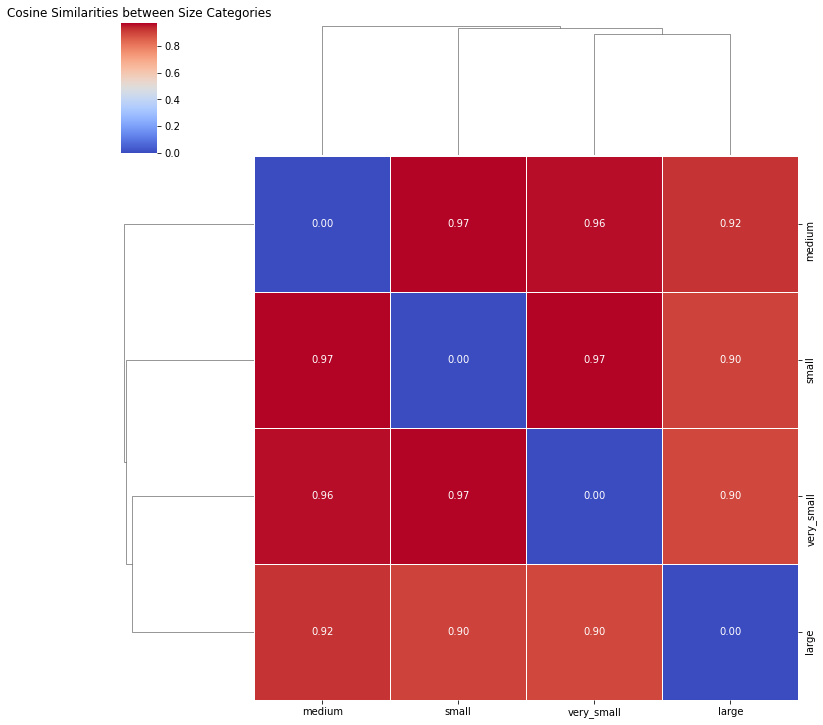

In [42]:
# Constructing data for heat map but larger.
cosine_df = pd.DataFrame(cosine_matrix, index=labels, columns=labels)

# Plotting larger heat map with data labels.
plt.figure(figsize=(10, 8))
sns.clustermap(cosine_df, cmap='coolwarm', annot=True,
               fmt=".2f", linewidths=.5)
plt.title('Cosine Similarities between Size Categories')
plt.show()

In [43]:
# Output to .csv for Power BI use
cosine_df.to_csv("cosinesims.csv")

### Predict Large or Very Small

In [44]:
predict_fire_size_and_find_terms(data, ['very_small', 'large'])

Accuracy: 0.8466579292267365
              precision    recall  f1-score   support

  very_small       0.79      0.93      0.85       368
       large       0.92      0.77      0.84       395

    accuracy                           0.85       763
   macro avg       0.85      0.85      0.85       763
weighted avg       0.86      0.85      0.85       763

Most influential terms for 'large' fires:
protection: 3.718108998836952
native: 3.151282345500655
alaska: 2.5211122073163783
outfitter: 2.355129607497298
point: 2.338079766392345
salmon: 2.1463207244715155
scars: 2.0169853158547113
season: 1.99606026215945
spruce: 1.776826816362861
monitoring: 1.6525045519308041
bitterroot: 1.6234002685739402
trail: 1.6047872074392517
trinity: 1.601655020767839
outfitters: 1.582530492697004
cabin: 1.5252289859003731

Most influential terms for 'very_small' fires:
roads: -3.297736780144408
private: -2.6986444813720416
monsoonal: -2.1664427122274987
monsoon: -1.9253556230045052
sage: -1.613087884017363
te

### Predict Large or Small

In [45]:
predict_fire_size_and_find_terms(data, ['small', 'large'])

Accuracy: 0.8430851063829787
              precision    recall  f1-score   support

       small       0.81      0.87      0.84       359
       large       0.88      0.81      0.84       393

    accuracy                           0.84       752
   macro avg       0.84      0.84      0.84       752
weighted avg       0.85      0.84      0.84       752

Most influential terms for 'large' fires:
protection: 3.3486593113577188
native: 3.255393931076179
alaska: 2.542214235393439
outfitter: 2.2671076769367904
scars: 2.2241207585323233
bitterroot: 2.220027737634488
point: 2.041228645228332
yosemite: 1.933195969016072
salmon: 1.7521701558317717
fork: 1.5871055103941114
moderated: 1.5773152781133002
outfitters: 1.5754039637398563
trinity: 1.5368515559852474
season: 1.5312395028008863
allotments: 1.4891486376415697

Most influential terms for 'small' fires:
monsoon: -2.9628664626175025
monsoonal: -2.728054225498229
roads: -2.240626140155748
habitat: -2.229571149191678
canyon: -1.88539438370862

### Predict Large or Medium

In [46]:
predict_fire_size_and_find_terms(data, ['medium', 'large'])

Accuracy: 0.8005215123859192
              precision    recall  f1-score   support

      medium       0.76      0.89      0.82       389
       large       0.86      0.71      0.78       378

    accuracy                           0.80       767
   macro avg       0.81      0.80      0.80       767
weighted avg       0.81      0.80      0.80       767

Most influential terms for 'large' fires:
protection: 3.0784352298288997
native: 2.9333441173100554
alaska: 2.5923209252123782
bitterroot: 2.406094086311893
middle: 1.8154937748415834
outfitter: 1.727971967238628
lolo: 1.5686339019431514
moose: 1.5406290605055906
remote: 1.5271559957743355
trinity: 1.5082599564029624
continues: 1.4285433676900225
monitor: 1.4044070170451128
scars: 1.3975491799478612
allotments: 1.3553258562644408
gila: 1.3492525612254784

Most influential terms for 'medium' fires:
sage: -2.514131280014576
private: -1.951745952465015
grouse: -1.9416989478755664
habitat: -1.881710890300471
gas: -1.3599736300321958
steep: 

### Predict Medium or Small

In [47]:
predict_fire_size_and_find_terms(data, ['small', 'medium'])

Accuracy: 0.7207792207792207
              precision    recall  f1-score   support

       small       0.75      0.67      0.71       392
      medium       0.69      0.77      0.73       378

    accuracy                           0.72       770
   macro avg       0.72      0.72      0.72       770
weighted avg       0.72      0.72      0.72       770

Most influential terms for 'medium' fires:
structures: 1.8029774964464742
outfitter: 1.4013324579405735
wilderness: 1.3848256719031231
popular: 1.3834950937483137
hwy: 1.2800921336202364
large: 1.2727776517175557
portion: 1.2057656666701466
salmon: 1.1936643535227822
golden: 1.1930413871616343
elevation: 1.176777747368168
fork: 1.152127457586857
dead: 1.0954944759921492
developed: 1.0937704896880258
manage: 1.0692428663701257
moderated: 1.0433382590384002

Most influential terms for 'small' fires:
lava: -2.3026879534198335
monsoonal: -2.152334351153151
monsoon: -1.9081855005150603
canyon: -1.4594432892082445
roads: -1.4053123239376595
d

### Predict Medium or Very Small

In [48]:
predict_fire_size_and_find_terms(data, ['very_small', 'medium'])

Accuracy: 0.7084398976982097
              precision    recall  f1-score   support

  very_small       0.67      0.76      0.71       375
      medium       0.75      0.66      0.70       407

    accuracy                           0.71       782
   macro avg       0.71      0.71      0.71       782
weighted avg       0.71      0.71      0.71       782

Most influential terms for 'medium' fires:
barriers: 1.703868883556061
habitat: 1.5967717136602435
tree: 1.5905955104866394
closures: 1.4359067198690239
trout: 1.4349987489932936
salmon: 1.4305200087249743
sage: 1.4222343133445257
elevation: 1.4107331370109928
oil: 1.3252751696556393
outfitter: 1.2662074985574165
meadows: 1.2327019496143599
golden: 1.1895311063038043
dead: 1.170143197947915
entirely: 1.1599326967099106
wx: 1.1553343465305466

Most influential terms for 'very_small' fires:
roads: -2.4746199581794
monsoonal: -2.0417899867843734
lines: -1.794128562535764
easily: -1.4681849487844874
power: -1.4225037897672115
media: -1.3181

### Predict Small or Very Small 

In [49]:
predict_fire_size_and_find_terms(data, ['small', 'very_small'])

Accuracy: 0.7079530638852672
              precision    recall  f1-score   support

       small       0.73      0.66      0.69       384
  very_small       0.69      0.76      0.72       383

    accuracy                           0.71       767
   macro avg       0.71      0.71      0.71       767
weighted avg       0.71      0.71      0.71       767

Most influential terms for 'very_small' fires:
lines: 1.8525967327538642
rugged: 1.6867858135075189
structures: 1.4189128402193685
contained: 1.3808489220100888
identified: 1.2616564513365052
unit: 1.1818825918062583
good: 1.157811706533216
black: 1.1518606507340585
burned: 1.1517572382194436
beetle: 1.124471263712029
refuge: 1.113688387042402
influence: 1.0959630065909307
regional: 1.0649937412210126
kbdi: 1.0469378567433085
media: 1.0345306330299606

Most influential terms for 'small' fires:
park: -1.8615066452672735
canyon: -1.8342846616770314
habitat: -1.8227231736380518
oil: -1.788530994768353
rated: -1.5601010840336866
lava: -1.55

### Predict From All

In [50]:
# Use penalized logistic regression to predict between all bin sizes.

acre_texts = data['combined_text']
acre_labels = data['size_cat']
acre_x = vectorizer.fit_transform(acre_texts)

acre_model, acrex_train, acrex_test,\
acrey_train, acrey_test = train_logistic_reg(acre_texts,acre_labels,'l2',1.1,1000)

acre_pred = acre_model.predict(acrex_test)
acre_score = accuracy_score(acrey_test, acre_pred)

print(f"A penalized logistic regression model classifying risk has an accuracy of {acre_score}\n")
print("Classification Report:")
print(classification_report(acrey_test, acre_pred))

A penalized logistic regression model classifying risk has an accuracy of 0.5707762557077626

Classification Report:
              precision    recall  f1-score   support

       large       0.71      0.66      0.69       394
      medium       0.50      0.47      0.49       392
       small       0.59      0.54      0.56       365
  very_small       0.50      0.61      0.55       382

    accuracy                           0.57      1533
   macro avg       0.58      0.57      0.57      1533
weighted avg       0.58      0.57      0.57      1533



###### Power BI Export

In [51]:
store_predict_fire_size_and_find_terms(data,['very_small','large'])

Accuracy: 0.8466579292267365
              precision    recall  f1-score   support

  very_small       0.79      0.93      0.85       368
       large       0.92      0.77      0.84       395

    accuracy                           0.85       763
   macro avg       0.85      0.85      0.85       763
weighted avg       0.86      0.85      0.85       763

Most influential terms for 'large' fires:
    Coefficient     Feature
0      3.718109  protection
1      3.151282      native
2      2.521112      alaska
3      2.355130   outfitter
4      2.338080       point
5      2.146321      salmon
6      2.016985       scars
7      1.996060      season
8      1.776827      spruce
9      1.652505  monitoring
10     1.623400  bitterroot
11     1.604787       trail
12     1.601655     trinity
13     1.582530  outfitters
14     1.525229       cabin

Most influential terms for 'very_small' fires:
    Coefficient      Feature
0     -0.000149      injured
1     -0.000288        onset
2     -0.000575    